In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from matplotlib import cm, colors, colorbar
import mne
from sklearn.svm import SVC
import scipy.stats as stats
from scipy.io import savemat
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


nrem_dataframe = pd.read_csv('nrem_dataframe.csv') # previously saved dataset
# mat_contents = sio.loadmat('spectral_slope_output.mat')


In [2]:
nrem_dataframe

ID  Visit  SA         Date_Time  Date     Time  Stage  \
0     2000      1   5  11/19/0014 03:42   NaN  3:42 AM    2.0   
1     2000      1   1  11/19/0014 01:00   NaN  1:00 AM    2.0   
2     2000      1   9  11/19/0014 06:07   NaN  6:07 AM    NaN   
3     2000      1   7  11/19/0014 05:08   NaN  5:08 AM    2.0   
4     2000      1   2  11/19/0014 01:38   NaN  1:38 AM    2.0   
...    ...    ...  ..               ...   ...      ...    ...   
1085  2144      3   7  11/10/0017 03:59   NaN  3:59 AM    2.0   
1086  2144      3  10  11/10/0017 05:21   NaN  5:21 AM    2.0   
1087  2144      3   2  11/10/0017 01:10   NaN  1:10 AM    2.0   
1088  2144      3   3  11/10/0017 01:30   NaN  1:30 AM    2.0   
1089  2144      3   5  11/10/0017 02:34   NaN  2:34 AM    2.0   

      Q1ExperienceNum Q1Experience  \
0                 3.0       Report   
1                 3.0       Report   
2                 3.0       Report   
3                 3.0       Report   
4                 3.0       Report   
...               ...          ...   
1085              3.0       Report   
1086              3.0       Report   
1087              1.0     NoReport   
1088              3.0       Report   
1089              3.0       Report   

                                               Q1Report  ...   N1   N2   N3  \
0     Heating things for health benefits. Doing diff...  ...  0.0  1.0  0.0   
1                            Food or herbal supplements  ...  0.0  1.0  0.0   
2     Drive in a car with a friend going to the bank...  ...  0.0  1.0  0.0   
3                                               walking  ...  0.0  1.0  0.0   
4               Was trying to recall the previous dream  ...  0.0  1.0  0.0   
...                                                 ...  ...  ...  ...  ...   
1085          describing a contest for naming something  ...  0.0  1.0  1.0   
1086  At the table, facing older gentleman who had a...  ...  0.0  1.0  0.0   
1087                                                NaN  ...  0.0  1.0  0.0   
1088  something on its head sitting in a chair - no ...  ...  0.0  1.0  0.0   
1089  In a long line and people in chairs around a l...  ...  0.0  1.0  0.0   

      REM  WAKE  OFFLINE_SLEEP_SCORE  \
0     0.0   1.0                   N2   
1     0.0   1.0                   N2   
2     0.0   1.0                   N2   
3     0.0   1.0                   N2   
4     0.0   1.0                   N2   
...   ...   ...                  ...   
1085  0.0   1.0                  NaN   
1086  0.0   1.0                  NaN   
1087  0.0   1.0                  NaN   
1088  0.0   1.0                  NaN   
1089  0.0   1.0                  NaN   

                                                   PATH  \
0     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/...   
1     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/...   
2     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/...   
3     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/...   
4     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/...   
...                                                 ...   
1085  /data/tvanasse/nccam3/data/sub-2144/eeg/ses-3/...   
1086  /data/tvanasse/nccam3/data/sub-2144/eeg/ses-3/...   
1087  /data/tvanasse/nccam3/data/sub-2144/eeg/ses-3/...   
1088  /data/tvanasse/nccam3/data/sub-2144/eeg/ses-3/...   
1089  /data/tvanasse/nccam3/data/sub-2144/eeg/ses-3/...   

                                           SES_PATH  \
0     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1   
1     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1   
2     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1   
3     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1   
4     /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1   
...                                             ...   
1085  /data/tvanasse/nccam3/data/sub-2144/eeg/ses-3   
1086  /data/tvanasse/nccam3/data/sub-2144/eeg/ses-3   
1087  /data/tvanasse/nccam3/data/sub-2144/eeg/ses-3   
1088  /data/tvanasse/nccam3/data/sub-2144/eeg/ses-3   
1089  /data/tvanasse/nccam

In [3]:
# set data origin folder
data_folder = "/data/tvanasse/nccam3/data/"

### Aquire Point spectral density in 60 seconds before awakening

In [ ]:
time_before_awakening = 60

nrem_dataframe["PSDS_60SEC_1TO50HZ"] = np.array(0).astype('object') #create object so arrays can be added

psds_list = []
for i in range(0,len(nrem_dataframe)):
    print(i)
    start_index = nrem_dataframe['PATH'][i].find('sub')
    nrem_dataframe.loc[i,'SHORT_PATH'] = nrem_dataframe['PATH'][i][start_index:]

    raw = mne.io.read_raw_eeglab(data_folder + nrem_dataframe['PATH'][i][start_index:])

    psds, freqs = mne.time_frequency.psd_welch(raw,
                                               tmin = raw.times[-1]-time_before_awakening,
                                               tmax = raw.times[-1],
                                               fmin=1., fmax=50.,
                                               n_fft=2048,
                                               average='mean',
                                               n_overlap = 2048/2,
    #                                            n_jobs=15)
                                              )
    print(psds.shape)
    print(freqs.shape)
    nrem_dataframe.at[i,"PSDS_60SEC_1TO50HZ"] = psds.tolist()

nrem_dataframe.to_pickle("/data/tvanasse/nccam3/data/post_process_data/nrem_dataframe_psdextraction_" +\
                         str(time_before_awakening) +  "s.pkl")
np.save("figures/freqs",freqs)

In [5]:
freqs = np.load("figures/freqs.npy")

time_before_awakening = 60

nrem_dataframe = pd.read_pickle("/data/tvanasse/nccam3/data/post_process_data/nrem_dataframe_psdextraction_" +\
                                str(time_before_awakening) + "s.pkl")

## FILTER OUT SUBJECTS WITHOUT REPORT/SOMETHING && NO REPORT
check = np.load('./sub_q1_data/sub_reportorsomethingandnoreport.npy')
print("Including subjects:")
print(check)
nrem_dataframe = nrem_dataframe[nrem_dataframe.ID.isin(check)].reset_index(drop=True)

nrem_dataframe["REPORT_BINARY"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,
                   "REPORT_BINARY"] = 1

nrem_dataframe["REPORT_BINARY_B"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] == "Report")].index,
                   "REPORT_BINARY_B"] = 1


Including subjects:
[2000 2001 2002 2004 2005 2006 2008 2009 2010 2011 2012 2016 2019 2020
 2022 2023 2026 2027 2028 2029 2030 2031 2032 2034 2035 2037 2041 2046
 2047 2048 2049 2051 2052 2053 2054 2055 2056 2058 2060 2061 2063 2064
 2065 2066 2067 2068 2069 2070 2071 2073 2075 2078 2079 2080 2083 2084
 2085 2086 2087 2088 2091 2092 2094 2096 2097 2099 2101 2102 2103 2104
 2105 2106 2111 2112 2114 2116 2121 2122 2123 2126 2127 2128 2133 2134
 2140 2142 2144]


##### PSD of 185 channels--200 freq bins--as feature matrix (PCA REDUCED): 2-CLASS

In [6]:
from sklearn.decomposition import PCA

# organize frequenices into frequency matrix
features = []
for i in range(0,len(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values)):
    if i%100 == 0:
        print(str(i) + " of " + str(len(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values)))
    y = []
    for chan in range(0,185):
        y.append(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[chan,:])
    
    features.append(np.array(y).flatten('F'))
    
features = np.array(features)

print("features: " + str(features.shape))

y_a = nrem_dataframe["REPORT_BINARY"].copy().values
print("y: " + str(y.shape))

# dream w/ recall vs. dream w/o recall and no experience
y_b = nrem_dataframe["REPORT_BINARY_B"].copy().values

groups = nrem_dataframe["ID"].values
print("groups: " + str(groups.shape))

# standardize features
features_std = preprocessing.scale(features)

0 of 986


KeyboardInterrupt: 

604
features (PCA reduced): (986, 5)


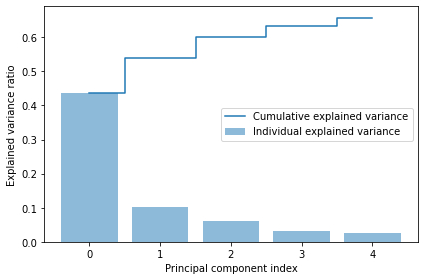

nested_score: 
[0.52478814 0.6011648  0.49310777 0.5051306  0.5775641  0.54107143
 0.52412281 0.56003584 0.5956106  0.65792812]
0.55805242021961
0
274
features (PCA reduced): (986, 5)


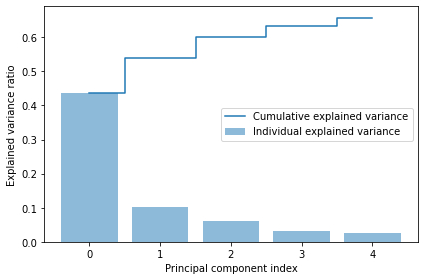

nested_score: 
[0.59833333 0.5625     0.51810811 0.51975764 0.60540541 0.54506641
 0.48191781 0.55160985 0.59882479 0.55104895]
0.5532572294207504
1
274
features (PCA reduced): (986, 5)


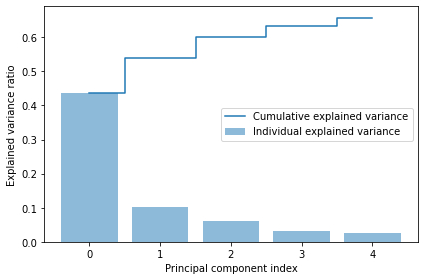

nested_score: 
[0.52272727 0.52313883 0.58128079 0.52158444 0.51811594 0.45886076
 0.41987179 0.46609285 0.50821918 0.47917808]
0.49990699442155256
2
604
features (PCA reduced): (986, 10)


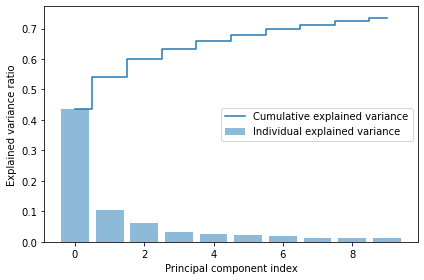

nested_score: 
[0.61800847 0.6354616  0.53383459 0.43983209 0.61217949 0.63459821
 0.55131579 0.47670251 0.53150804 0.55433404]
0.558777483336347
0
274
features (PCA reduced): (986, 10)


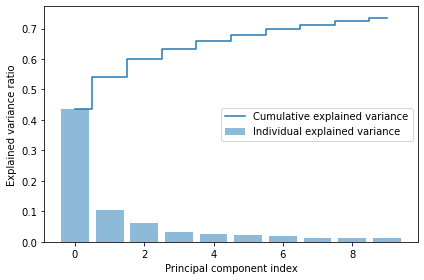

nested_score: 
[0.56333333 0.6087963  0.55783784 0.54847208 0.61864865 0.5170778
 0.49616438 0.51278409 0.54113248 0.52820513]
0.5492452072155274
1
274
features (PCA reduced): (986, 10)


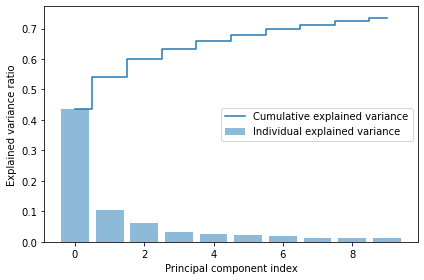

nested_score: 
[0.50757576 0.53294769 0.48374384 0.50711575 0.47608696 0.54810127
 0.41987179 0.4494001  0.51780822 0.48712329]
0.4929774663977923
2
604
features (PCA reduced): (986, 20)


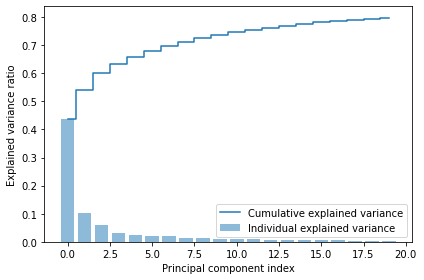

nested_score: 
[0.59788136 0.57786885 0.53947368 0.54640858 0.55576923 0.65803571
 0.61096491 0.49865591 0.55280313 0.58816068]
0.5726022051612525
0
274
features (PCA reduced): (986, 20)


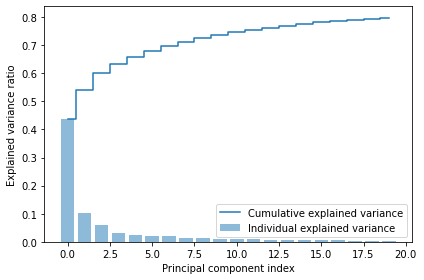

nested_score: 
[0.5775     0.5787037  0.57135135 0.57323498 0.61162162 0.60365275
 0.55616438 0.53503788 0.54807692 0.54382284]
0.5699166441543004
1
274
features (PCA reduced): (986, 20)


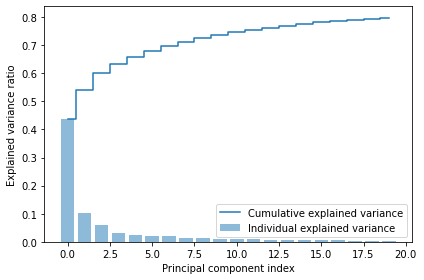

nested_score: 
[0.52272727 0.49119718 0.50517241 0.53012334 0.53333333 0.46550633
 0.42147436 0.45957225 0.49835616 0.50082192]
0.49282845611954507
2
604
features (PCA reduced): (986, 50)


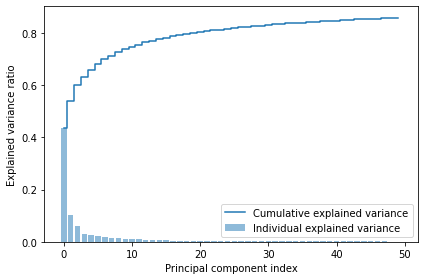

nested_score: 
[0.59300847 0.62381363 0.56516291 0.6068097  0.51666667 0.63861607
 0.59868421 0.51478495 0.56562364 0.6038055 ]
0.5826975749360433
0
274
features (PCA reduced): (986, 50)


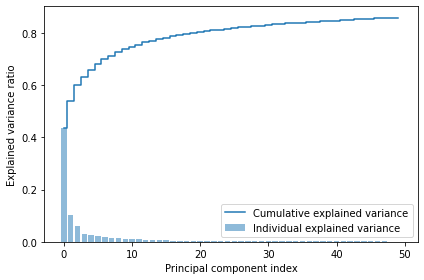

nested_score: 
[0.5425     0.64814815 0.57783784 0.58561644 0.50540541 0.61100569
 0.54931507 0.54308712 0.52884615 0.52843823]
0.562020009433683
1
274
features (PCA reduced): (986, 50)


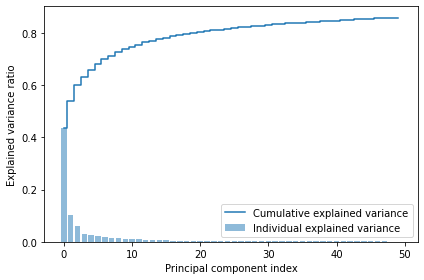

nested_score: 
[0.50757576 0.49924547 0.5682266  0.5        0.52173913 0.51012658
 0.42147436 0.44366197 0.49205479 0.46767123]
0.49317759023138696
2
604
features (PCA reduced): (986, 100)


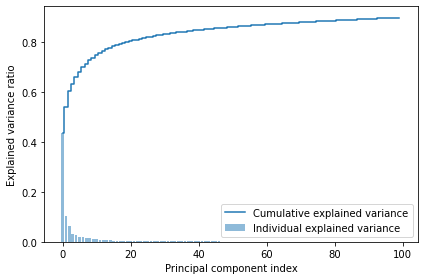

nested_score: 
[0.62690678 0.64516825 0.62092732 0.56133396 0.50833333 0.65424107
 0.60263158 0.5031362  0.57822686 0.58054968]
0.5881455026859974
0
274
features (PCA reduced): (986, 100)


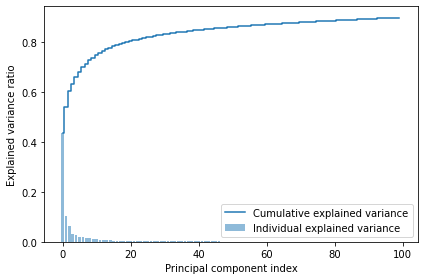

nested_score: 
[0.52166667 0.62962963 0.56459459 0.57323498 0.52567568 0.61100569
 0.56356164 0.49621212 0.58279915 0.55198135]
0.5620361505688309
1
274
features (PCA reduced): (986, 100)


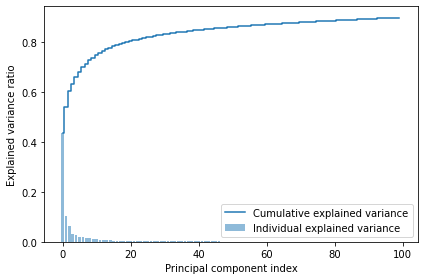

nested_score: 
[0.53030303 0.49547284 0.55394089 0.52775142 0.51014493 0.51202532
 0.39690171 0.40584246 0.51041096 0.48136986]
0.4924163414666512
2
604
features (PCA reduced): (986, 150)


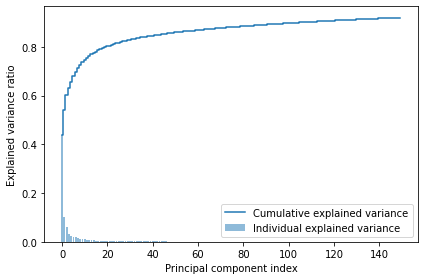

nested_score: 
[0.61440678 0.64020708 0.58521303 0.57625933 0.46602564 0.63727679
 0.60614035 0.53897849 0.56540635 0.60782241]
0.583773624312152
0
274
features (PCA reduced): (986, 150)


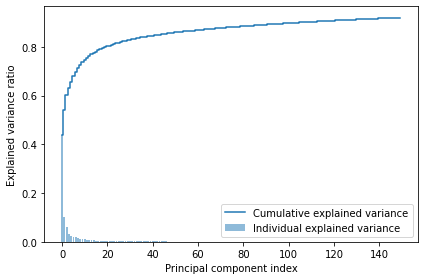

nested_score: 
[0.50833333 0.58564815 0.56459459 0.52924131 0.51891892 0.61100569
 0.49041096 0.55018939 0.56356838 0.55174825]
0.5473658974893314
1
274
features (PCA reduced): (986, 150)


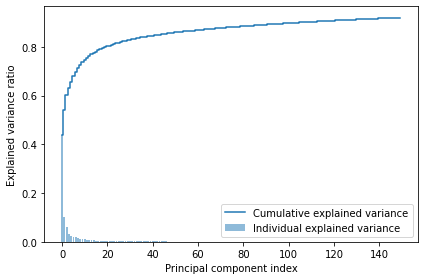

nested_score: 
[0.48484848 0.50251509 0.55394089 0.54625237 0.49710145 0.52468354
 0.40384615 0.44131455 0.51945205 0.46136986]
0.4935324453231903
2
604
features (PCA reduced): (986, 200)


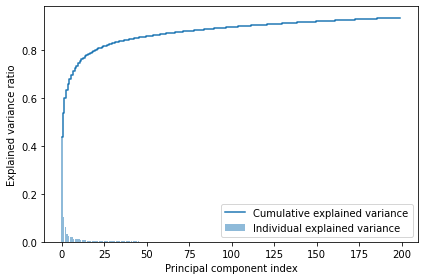

nested_score: 
[0.61440678 0.65660052 0.5764411  0.56809701 0.49294872 0.6671875
 0.60614035 0.54121864 0.56953498 0.58964059]
0.5882216198605081
0
274
features (PCA reduced): (986, 200)


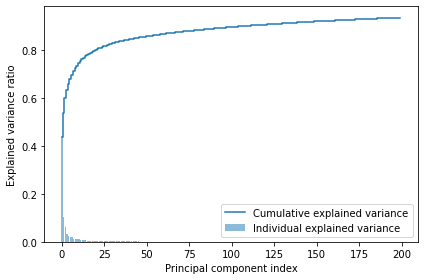

nested_score: 
[0.46666667 0.5625     0.58486486 0.53609062 0.55891892 0.52395636
 0.53041096 0.55776515 0.52510684 0.53659674]
0.5382877113516589
1
274
features (PCA reduced): (986, 200)


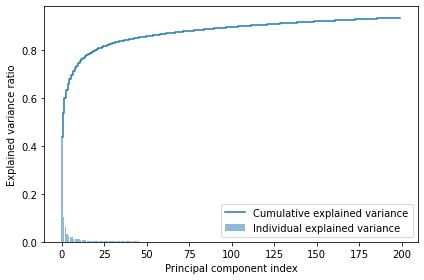

nested_score: 
[0.5        0.50251509 0.56108374 0.5        0.52826087 0.49968354
 0.40384615 0.47548252 0.49452055 0.46136986]
0.4926762337837996
2
604
features (PCA reduced): (986, 250)


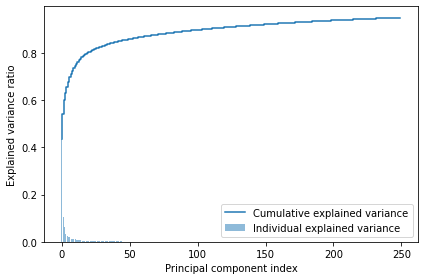

nested_score: 
[0.63135593 0.60893011 0.55576441 0.5755597  0.49294872 0.64642857
 0.60614035 0.55510753 0.57800956 0.5961945 ]
0.5846439388257015
0
274
features (PCA reduced): (986, 250)


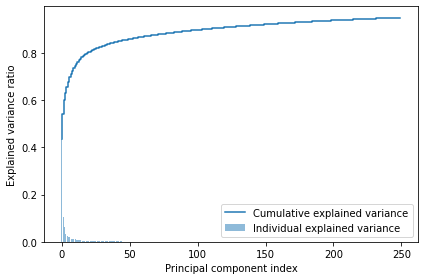

nested_score: 
[0.48       0.54398148 0.58486486 0.52370917 0.55891892 0.52395636
 0.47013699 0.54214015 0.53205128 0.53636364]
0.5296122845777732
1
274
features (PCA reduced): (986, 250)


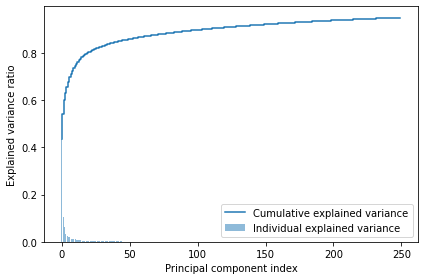

nested_score: 
[0.56060606 0.50251509 0.55098522 0.52632827 0.5115942  0.49968354
 0.4107906  0.46400626 0.50136986 0.45506849]
0.49829476075072165
2
604
features (PCA reduced): (986, 300)


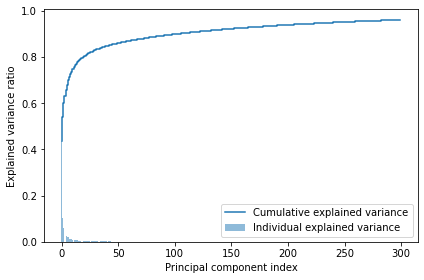

nested_score: 
[0.63135593 0.63028473 0.55827068 0.5755597  0.51794872 0.659375
 0.575      0.54121864 0.56953498 0.57293869]
0.5831487068550164
0
274
features (PCA reduced): (986, 300)


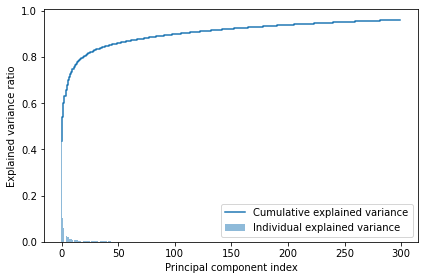

nested_score: 
[0.48666667 0.5787037  0.61837838 0.53055848 0.61216216 0.52395636
 0.52410959 0.54214015 0.5267094  0.50629371]
0.5449678598819787
1
274
features (PCA reduced): (986, 300)


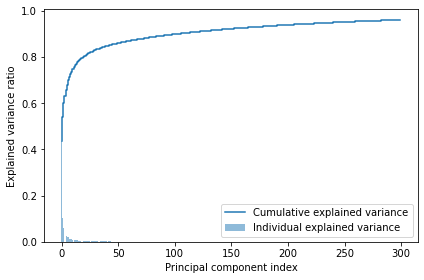

nested_score: 
[0.5530303  0.51458753 0.55812808 0.52632827 0.49492754 0.49968354
 0.41773504 0.47887324 0.51506849 0.44191781]
0.5000279844320932
2


In [188]:
from sklearn import preprocessing
import scipy

y_shuff = nrem_dataframe["REPORT_BINARY_B"].copy().values
np.random.shuffle(y_shuff)

mean_accuracy_a = []
std_accuracy_a = []

mean_accuracy_b = []
std_accuracy_b = []

mean_accuracy_shuff = []
std_accuracy_shuff = []

for n_comp in [5,10,20,50,100,150,200,250,300]:
    
    y_iter = 0
    for y_test in [y_a,y_b,y_shuff]:
        print(np.sum(y_test))
        pca = PCA(n_components=n_comp)
        features_r = pca.fit(features_std).transform(features_std)
        print("features (PCA reduced): " + str(features_r.shape))

        # Determine explained variance using explained_variance_ration_ attribute
        #
        exp_var_pca = pca.explained_variance_ratio_
        #
        # Cumulative sum of eigenvalues; This will be used to create step plot
        # for visualizing the variance explained by each principal component.
        #
        cum_sum_eigenvalues = np.cumsum(exp_var_pca)
        #
        # Create the visualization plot
        #
        plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
        plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

    #     fig, axes = plt.subplots(figsize=(17,17))
    #     plt.imshow(features_r)
    #     plt.xlabel('Feature')
    #     plt.ylabel('Sample (Night)')
    #     plt.show()

        from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
        n_jobs = 50

        # Set up possible values of parameters to optimize over
        p_grid = {"C": [0.1, 1, 5, 10, 100, 500],
                  "gamma": [0.0001, 0.001,.01, .05, .1]}

        # We will use a Support Vector Classifier with "rbf" kernel
        svm = SVC(kernel="rbf",
                  class_weight="balanced")

        # Choose cross-validation techniques for the inner and outer loops,
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
        #     inner_cv = LeaveOneGroupOut()

        outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)
        #     outer_cv = LeaveOneGroupOut()

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=svm, 
                           param_grid=p_grid, 
                           scoring='balanced_accuracy',
                           cv=inner_cv,
                           refit=True)

        nested_score = cross_val_score(clf, 
                               X=features_r, 
                               y=y_test,
                               cv=outer_cv,
                               n_jobs=n_jobs,
        #                            groups=groups_ws,
                               scoring='balanced_accuracy') 

        print("nested_score: ")
        print(nested_score)
        print(nested_score.mean())

        print(y_iter)
        if y_iter == 0:
            mean_accuracy_a.append(nested_score.mean())
            std_accuracy_a.append(scipy.stats.sem(nested_score))
        
        elif y_iter == 1:
            mean_accuracy_b.append(nested_score.mean())
            std_accuracy_b.append(scipy.stats.sem(nested_score))
            
        else:
            mean_accuracy_shuff.append(nested_score.mean())
            std_accuracy_shuff.append(scipy.stats.sem(nested_score))
        
        
        y_iter = y_iter +1

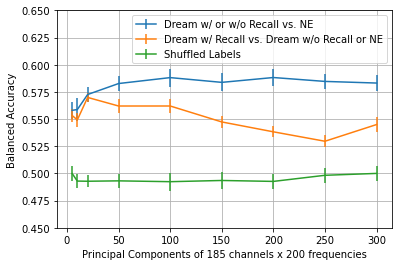

In [190]:
# plt.plot(np.array(mean_accuracy))
plt.errorbar([5,10,20,50,100,150,200,250,300], np.array(mean_accuracy_a), 
             yerr=np.array(std_accuracy_a)/2,label="Dream w/ or w/o Recall vs. NE")
plt.errorbar([5,10,20,50,100,150,200,250,300], np.array(mean_accuracy_b), 
             yerr=np.array(std_accuracy_b)/2, label="Dream w/ Recall vs. Dream w/o Recall or NE")
plt.errorbar([5,10,20,50,100,150,200,250,300], np.array(mean_accuracy_shuff), 
             yerr=np.array(std_accuracy_shuff)/2, label="Shuffled Labels")

plt.ylabel("Balanced Accuracy")
plt.ylim(.45,.65)
plt.grid()
plt.xlabel("Principal Components of 185 channels x 200 frequencies")
plt.legend()
plt.savefig("figures/pca_accuracies",dpi=300)

Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Component Rank: 1


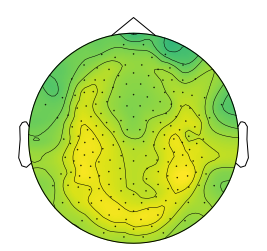

Component Rank: 2


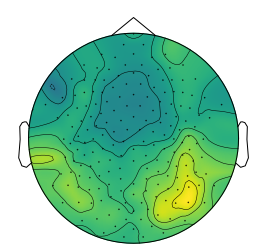

Component Rank: 3


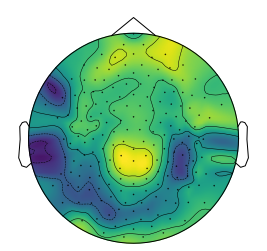

Component Rank: 4


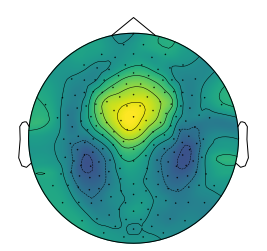

Component Rank: 5


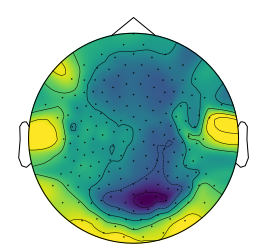

Component Rank: 6


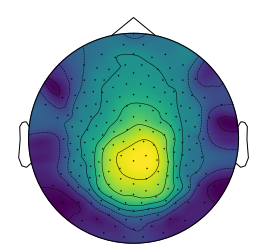

Component Rank: 7


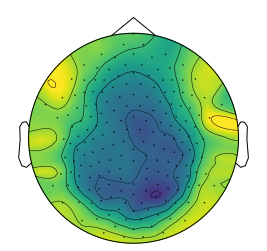

Component Rank: 8


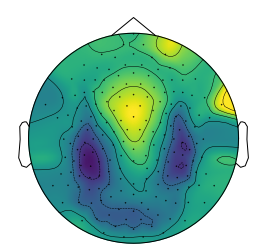

Component Rank: 9


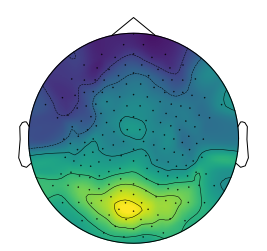

Component Rank: 10


Component Rank: 11


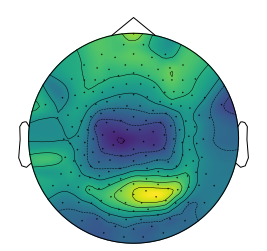

Component Rank: 12


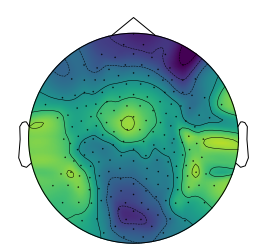

Component Rank: 13


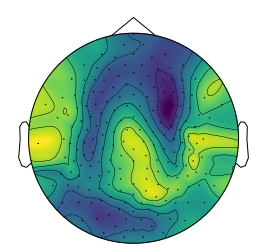

Component Rank: 14


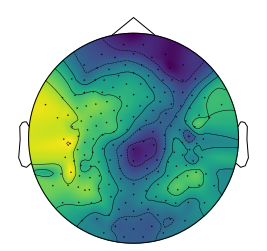

Component Rank: 15


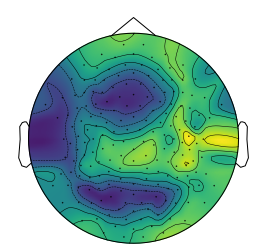

Component Rank: 16


KeyboardInterrupt: 

In [93]:
raw = mne.io.read_raw_eeglab('/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.set')

## ONLY FOR PLOTTING, MNE reads positions as meters
for i in range(len(raw.info['chs'])):
    raw.info['chs'][i]['loc'] = raw.info['chs'][i]['loc']/121
    
# plot components
for comp in range(0,20):
    print("Component Rank: " + str(comp + 1))
    channel_sum_ranking = []
    for i in range(0,185):
#         end_shape = np.array(nrem_dataframe["TF"].values[0]).shape
        end_shape = (185, 200)
        channel_sum_ranking.append(np.sum(pca.components_[comp].reshape(end_shape, order='F')[i,:]))
#         channel_sum_ranking.append(np.sum(np.absolute(pca.components_[comp][i:i+324])))
    # Plot the topography of ranking
    mne.viz.plot_topomap(np.array(channel_sum_ranking), 
                         raw.info, 
    #                      vmin=1, 
    #                      vmax=2, 
                         cmap=cm.viridis,)
    plt.show()

In [ ]:
n_comp = 150
    
pca = PCA(n_components=n_comp)
features_r = pca.fit(features_std).transform(features_std)
print("features (PCA reduced): " + str(features_r.shape))

print(features_r.shape)
X_projected = pca.inverse_transform(features_r)
print(X_projected.shape)
X = X_projected[:,0:185*200].reshape([986,185,200], order='F')
print(X.shape)

orig = features.reshape([986,185,200], 
                        order='F')

channel = 1

Orig_chanavg = np.average(orig,channel)
for i in range(0,1000,25):
    plt.plot(Orig_chanavg[i,:])
plt.yscale('log')
plt.title('Original Data, Channel ' + str(channel))
plt.show()

X_chanavg = np.average(X,channel)
for i in range(0,1000,25):
    plt.plot(X_chanavg[i,:])
# plt.yscale('log')
plt.title("Back Projected, Channel " + str(channel))
plt.show()

In [ ]:

adj, names = mne.channels.find_ch_adjacency(raw.info, 'eeg')

channel_mean_accuracy = []

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
n_jobs = 30

for k in range(0,len(names)):
# for k in [150, 21]:
    neigh_idx = np.where(adj[k, :].toarray().ravel())[0]
    neigh_names = [names[i] for i in neigh_idx]
    print(f"{names[k]} is next to {neigh_names}")
    
    neighbor_indices = []
    for i in range(0,len(neigh_names)):
        neighbor_indices.append(names.index(neigh_names[i])) # add neighbors
    neighbor_indices = np.array(neighbor_indices)
    print(neighbor_indices)
    
    #     # Set up possible values of parameters to optimize over
    p_grid = {"C": [0.1, 1, 5, 10, 100, 500],
              "gamma": [0.0001, 0.001,.01, .05, .1]}

    # We will use a Support Vector Classifier with "rbf" kernel
    svm = SVC(kernel="rbf",
              class_weight="balanced")

    # Choose cross-validation techniques for the inner and outer loops,
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    #     inner_cv = LeaveOneGroupOut()

    outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)
    #     outer_cv = LeaveOneGroupOut()

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, 
                       param_grid=p_grid, 
                       scoring='balanced_accuracy',
                       cv=inner_cv,
                       refit=True)

    nested_score = cross_val_score(clf, 
                           X=X[:,neighbor_indices,:].reshape([986,len(neighbor_indices)*200], order='F'), 
                           y=y,
                           cv=outer_cv,
                           n_jobs=n_jobs,
    #                            groups=groups_ws,
                           scoring='balanced_accuracy') 

    print("nested_score: ")
    print(nested_score)
    print(nested_score.mean())
    
    channel_mean_accuracy.append(nested_score.mean())
    
channel_mean_accuracy = np.array(channel_mean_accuracy)
np.save("figures/searchlight", channel_mean_accuracy)



Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt


Text(0.5, 1.0, 'Searchlight Accuracy')

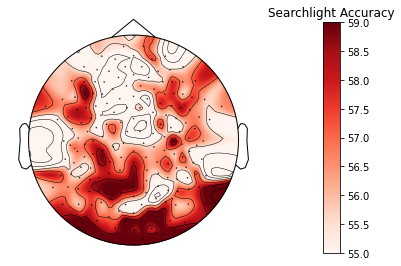

In [134]:
channel_mean_accuracy = np.load("figures/searchlight.npy")

raw = mne.io.read_raw_eeglab('/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.set')

## ONLY FOR PLOTTING, MNE reads positions as meters
for i in range(len(raw.info['chs'])):
    raw.info['chs'][i]['loc'] = raw.info['chs'][i]['loc']/121
    
fig, ax1 = plt.subplots(ncols=1)
    
im,cm = mne.viz.plot_topomap(np.array(channel_mean_accuracy)*100, 
                         raw.info,                          
                         axes = ax1,
                         show=False,
                         vmin=55, 
                         vmax=59)

# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.8
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title("Searchlight Accuracy",fontsize=12) # title on top of colorba

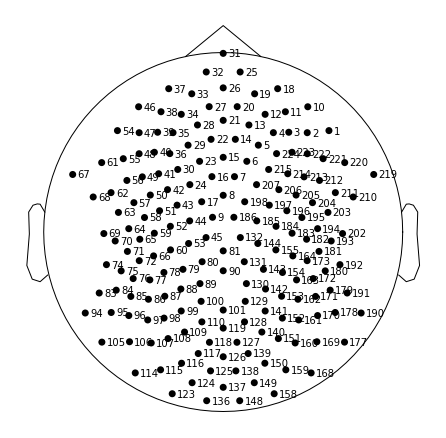

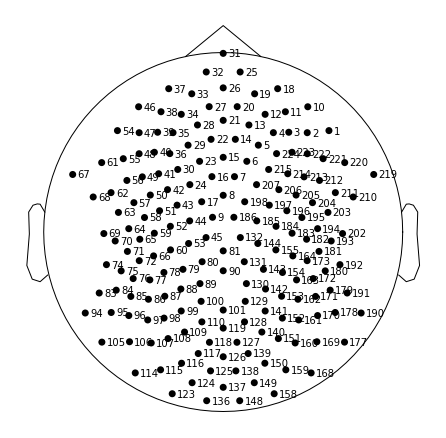

In [133]:
mne.viz.plot_sensors(raw.info, 
                     show_names=True)

In [155]:
k = names.index('126')
neigh_idx = np.where(adj[k, :].toarray().ravel())[0]
neigh_names = [names[i] for i in neigh_idx]
print(f"{names[k]} is next to {neigh_names}")

neighbor_indices = []
for i in range(0,len(neigh_names)):
    neighbor_indices.append(names.index(neigh_names[i])) # add neighbors
neighbor_indices = np.array(neighbor_indices)
print(neighbor_indices)

cluster = np.average(X[:,neighbor_indices,:],1)
print(cluster.shape)
cluster = cluster.reshape([986,1*200], order='F')

126 is next to ['117', '118', '125', '126', '127', '138', '139']
[105 106 110 111 112 120 121]
(986, 200)


In [156]:
freq_mean_accuracy = []
freq_std_accuracy = []

for i in range(0, 200, 10):

    from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
    n_jobs = 30


    #     # Set up possible values of parameters to optimize over
    p_grid = {"C": [0.1, 1, 5, 10, 100, 500],
              "gamma": [0.0001, 0.001,.01, .05, .1]}

    # We will use a Support Vector Classifier with "rbf" kernel
    svm = SVC(kernel="rbf",
              class_weight="balanced")

    # Choose cross-validation techniques for the inner and outer loops,
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    #     inner_cv = LeaveOneGroupOut()

    outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)
    #     outer_cv = LeaveOneGroupOut()

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, 
                       param_grid=p_grid, 
                       scoring='balanced_accuracy',
                       cv=inner_cv,
                       refit=True)

    nested_score = cross_val_score(clf, 
                           X=cluster[:,i:i+10], 
                           y=y,
                           cv=outer_cv,
                           n_jobs=n_jobs,
    #                            groups=groups_ws,
                           scoring='balanced_accuracy') 

    freq_mean_accuracy.append(nested_score.mean())
    freq_std_accuracy.append(scipy.stats.sem(nested_score))

freq_mean_accuracy = np.array(freq_mean_accuracy)
freq_std_accuracy = np.array(freq_std_accuracy)

np.save("figures/freq_searchlight", freq_mean_accuracy)


Text(0.5, 0, 'Frequency')

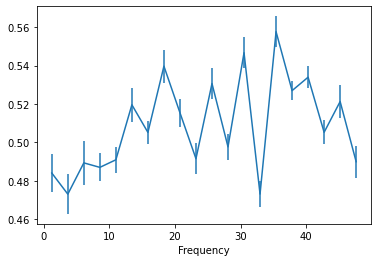

In [157]:
plt.errorbar(freqs[range(0,200,10)], 
             np.array(freq_mean_accuracy), 
             yerr=np.array(freq_std_accuracy)/2,label="Dream w/ or w/o Recall vs. NE")
plt.xlabel("Frequency")

In [ ]:
## 3-Class Classifier

1864.0
features (PCA reduced): (986, 5)


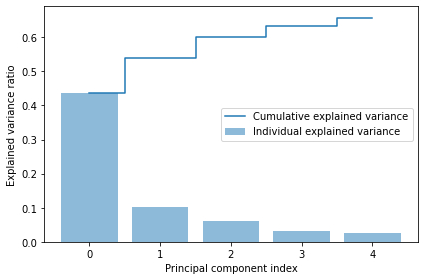

nested_score: 
[0.32896825 0.38248672 0.41414683 0.34836226 0.40698413 0.3983615
 0.34686717 0.35486111 0.44483294 0.37221048]
0.37980813777554623
0
1864.0
features (PCA reduced): (986, 5)


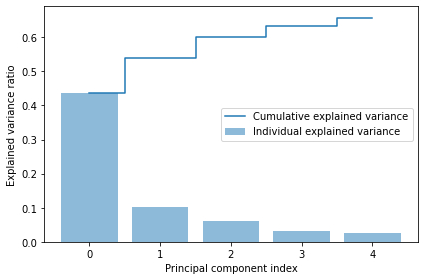

nested_score: 
[0.39386598 0.31981713 0.39648538 0.33013764 0.38260432 0.28065268
 0.34814221 0.33078858 0.31902916 0.40718954]
0.3508712631060103
1
1864.0
features (PCA reduced): (986, 10)


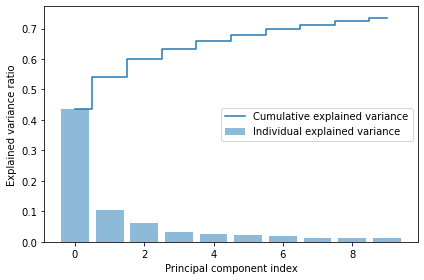

nested_score: 
[0.41071429 0.43603562 0.36869048 0.32512508 0.43379731 0.45976819
 0.34686717 0.28078704 0.4032634  0.38771435]
0.38527629265533814
0
1864.0
features (PCA reduced): (986, 10)


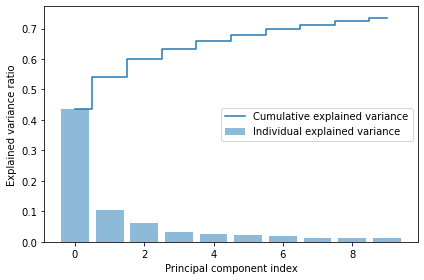

nested_score: 
[0.32818721 0.42482608 0.40322173 0.34454255 0.36551031 0.30182595
 0.32440052 0.30048555 0.33409212 0.41699346]
0.35440854916276254
1
1864.0
features (PCA reduced): (986, 20)


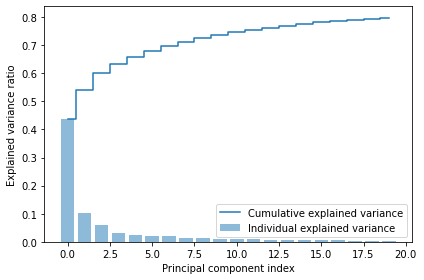

nested_score: 
[0.40357143 0.40570653 0.44367063 0.35524156 0.37382173 0.47174976
 0.39107769 0.3337963  0.48407148 0.4331689 ]
0.40958760151718526
0
1864.0
features (PCA reduced): (986, 20)


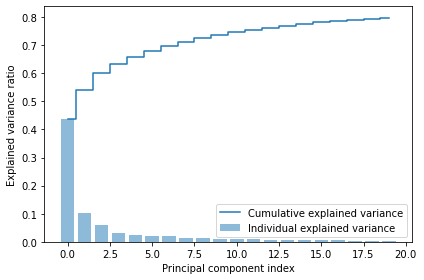

nested_score: 
[0.39750958 0.39815146 0.33333333 0.35947198 0.35947712 0.29731935
 0.30356719 0.29939355 0.34687872 0.36535948]
0.34604617586738434
1
1864.0
features (PCA reduced): (986, 50)


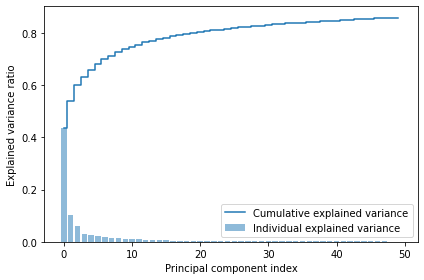

nested_score: 
[0.43849206 0.52014295 0.45371032 0.35776266 0.34818071 0.51476051
 0.43258145 0.37523148 0.47979798 0.44362227]
0.43642823956918103
0
1864.0
features (PCA reduced): (986, 50)


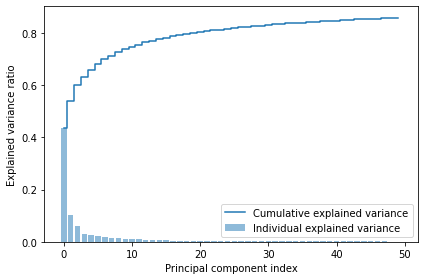

nested_score: 
[0.29663436 0.38757702 0.33333333 0.36760206 0.37053796 0.33484848
 0.33962488 0.33333333 0.33453304 0.24313725]
0.3341161732638755
1
1864.0
features (PCA reduced): (986, 100)


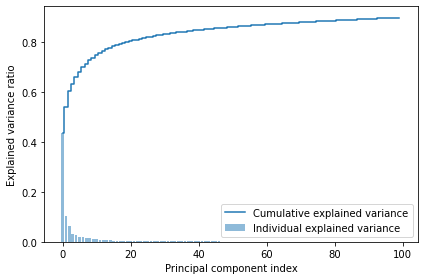

nested_score: 
[0.39325397 0.47064557 0.47795635 0.35191917 0.32151404 0.54390914
 0.39754386 0.39328704 0.41530692 0.46687808]
0.4232214127981043
0
1864.0
features (PCA reduced): (986, 100)


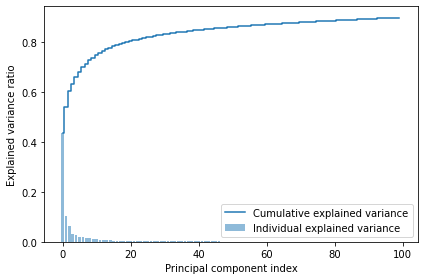

nested_score: 
[0.32555781 0.31713377 0.33333333 0.36760206 0.33333333 0.32940948
 0.3349359  0.33333333 0.35562528 0.31568627]
0.3345950576407229
1
1864.0
features (PCA reduced): (986, 150)


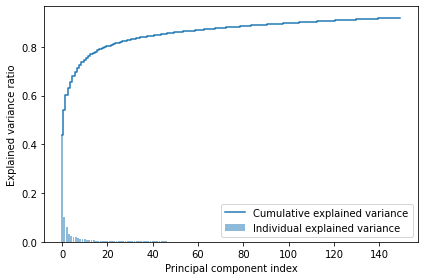

nested_score: 
[0.3984127  0.43397164 0.45123016 0.36806207 0.36903541 0.51042219
 0.45358396 0.38263889 0.41219891 0.4331689 ]
0.42127248291259295
0
1864.0
features (PCA reduced): (986, 150)


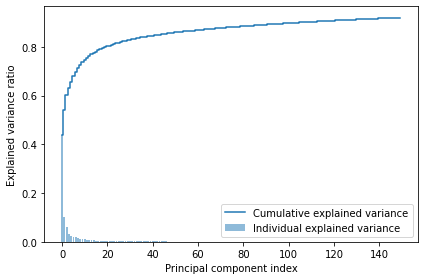

nested_score: 
[0.29886936 0.27592924 0.33333333 0.38807782 0.33333333 0.30376845
 0.34348291 0.33333333 0.33530208 0.18431373]
0.312974358305177
1
1864.0
features (PCA reduced): (986, 200)


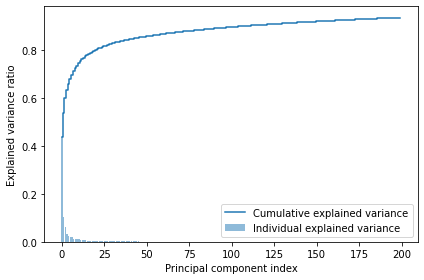

nested_score: 
[0.41468254 0.45266216 0.41414683 0.35283771 0.36522589 0.48127357
 0.40365915 0.3787037  0.41219891 0.41531595]
0.40907063969716884
0
1864.0
features (PCA reduced): (986, 200)


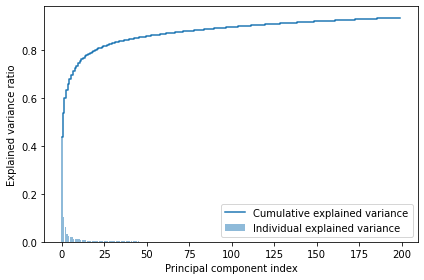

nested_score: 
[0.34201037 0.35418406 0.33333333 0.40304611 0.33333333 0.31563714
 0.34541192 0.33333333 0.35518436 0.18431373]
0.3299787684844907
1
1864.0
features (PCA reduced): (986, 250)


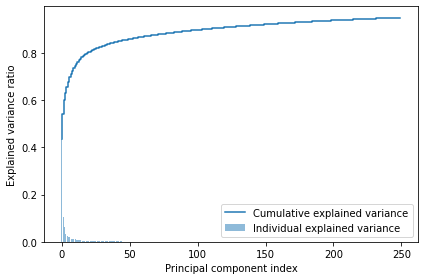

nested_score: 
[0.36904762 0.44908841 0.40200397 0.35981473 0.38710623 0.49137458
 0.39413534 0.39837963 0.42929293 0.38971106]
0.40699544862991627
0
1864.0
features (PCA reduced): (986, 250)


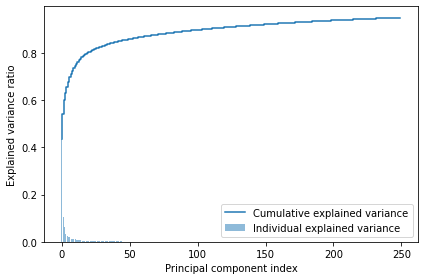

nested_score: 
[0.31710615 0.32770821 0.33333333 0.38416334 0.33333333 0.33311966
 0.32644824 0.33333333 0.37068824 0.28627451]
0.334550835363256
1
1864.0
features (PCA reduced): (986, 300)


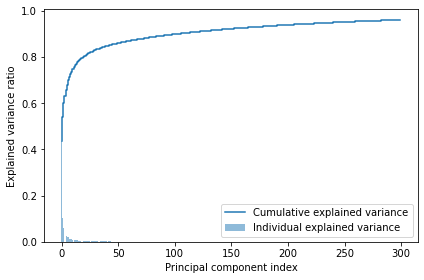

nested_score: 
[0.40357143 0.43420097 0.43789683 0.37836148 0.3813431  0.49137458
 0.39413534 0.39768519 0.3962704  0.37961005]
0.4094449351146133
0
1864.0
features (PCA reduced): (986, 300)


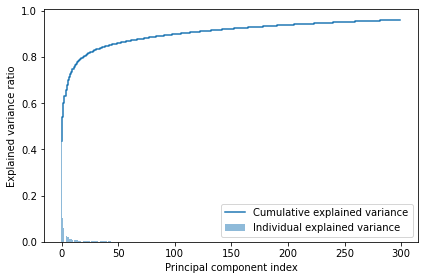

nested_score: 
[0.33333333 0.31995627 0.33333333 0.40566872 0.33333333 0.2791181
 0.32264957 0.33333333 0.37068824 0.26535948]
0.3296773715372904
1


In [183]:
from sklearn import preprocessing
import scipy

shuff_array = nrem_dataframe["Q1ExperienceNum"].copy().values
np.random.shuffle(shuff_array)

mean_accuracy_a = []
std_accuracy_a = []

mean_accuracy_shuff = []
std_accuracy_shuff = []

for n_comp in [5,10,20,50,100,150,200,250,300]:
    y_iter = 0
    for y_test in [nrem_dataframe["Q1ExperienceNum"].copy().values,
                   shuff_array]:
        print(np.sum(y_test))
        pca = PCA(n_components=n_comp)
        features_r = pca.fit(features_std).transform(features_std)
        print("features (PCA reduced): " + str(features_r.shape))

        # Determine explained variance using explained_variance_ration_ attribute
        #
        exp_var_pca = pca.explained_variance_ratio_
        #
        # Cumulative sum of eigenvalues; This will be used to create step plot
        # for visualizing the variance explained by each principal component.
        #
        cum_sum_eigenvalues = np.cumsum(exp_var_pca)
        #
        # Create the visualization plot
        #
        plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
        plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

    #     fig, axes = plt.subplots(figsize=(17,17))
    #     plt.imshow(features_r)
    #     plt.xlabel('Feature')
    #     plt.ylabel('Sample (Night)')
    #     plt.show()

        from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
        n_jobs = 50

        # Set up possible values of parameters to optimize over
        p_grid = {"C": [0.1, 1, 5, 10, 100, 500],
                  "gamma": [0.0001, 0.001,.01, .05, .1]}

        # We will use a Support Vector Classifier with "rbf" kernel
        svm = SVC(kernel="rbf",
                  class_weight="balanced")

        # Choose cross-validation techniques for the inner and outer loops,
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
        #     inner_cv = LeaveOneGroupOut()

        outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)
        #     outer_cv = LeaveOneGroupOut()

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=svm, 
                           param_grid=p_grid, 
                           scoring='balanced_accuracy',
                           cv=inner_cv,
                           refit=True)

        nested_score = cross_val_score(clf, 
                               X=features_r, 
                               y=y_test,
                               cv=outer_cv,
                               n_jobs=n_jobs,
        #                            groups=groups_ws,
                               scoring='balanced_accuracy') 

        print("nested_score: ")
        print(nested_score)
        print(nested_score.mean())

        print(y_iter)
        if y_iter == 0:
            mean_accuracy_a.append(nested_score.mean())
            std_accuracy_a.append(scipy.stats.sem(nested_score))

        else:
            mean_accuracy_shuff.append(nested_score.mean())
            std_accuracy_shuff.append(scipy.stats.sem(nested_score))


        y_iter = y_iter + 1

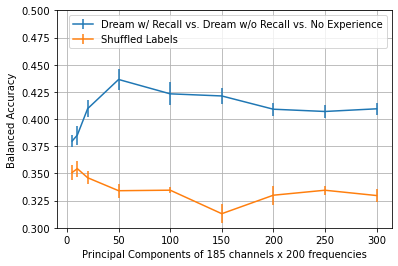

In [184]:
# plt.plot(np.array(mean_accuracy))
plt.errorbar([5,10,20,50,100,150,200,250,300], np.array(mean_accuracy_a), 
             yerr=np.array(std_accuracy_a)/2,label="Dream w/ Recall vs. Dream w/o Recall vs. No Experience")

plt.errorbar([5,10,20,50,100,150,200,250,300], np.array(mean_accuracy_shuff), 
             yerr=np.array(std_accuracy_shuff)/2,label="Shuffled Labels")


plt.ylabel("Balanced Accuracy")
plt.ylim(.30,.50)
plt.grid()
plt.xlabel("Principal Components of 185 channels x 200 frequencies")
plt.legend()
plt.savefig("figures/multiclass_pca_accuracies",dpi=300)

### Load Time-Frequency

In [15]:
freqs = np.load("figures/freqs.npy")

time_before_awakening = 60

nrem_dataframe = pd.read_pickle("/data/tvanasse/nccam3/data/post_process_data/nrem_dataframe_psdextraction_" +\
                                str(time_before_awakening) + "s_timefreq.pkl")

## FILTER OUT SUBJECTS WITHOUT REPORT/SOMETHING && NO REPORT
check = np.load('./sub_q1_data/sub_reportorsomethingandnoreport.npy')
print("Including subjects:")
print(check)
nrem_dataframe = nrem_dataframe[nrem_dataframe.ID.isin(check)].reset_index(drop=True)

nrem_dataframe["REPORT_BINARY"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,
                   "REPORT_BINARY"] = 1

nrem_dataframe["REPORT_BINARY_B"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] == "Report")].index,
                   "REPORT_BINARY_B"] = 1


features = []
for i in range(0,len(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values)):
    print(i)
    if len(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values[i]).shape) == 4:
        features.append(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values[i])[:,:,:,0].flatten('F')) # for some reason matlab spits out 
    else:
        features.append(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values[i]).flatten('F'))
        
features = np.vstack(np.array(features))

Including subjects:
[2000 2001 2002 2004 2005 2006 2008 2009 2010 2011 2012 2016 2019 2020
 2022 2023 2026 2027 2028 2029 2030 2031 2032 2034 2035 2037 2041 2046
 2047 2048 2049 2051 2052 2053 2054 2055 2056 2058 2060 2061 2063 2064
 2065 2066 2067 2068 2069 2070 2071 2073 2075 2078 2079 2080 2083 2084
 2085 2086 2087 2088 2091 2092 2094 2096 2097 2099 2101 2102 2103 2104
 2105 2106 2111 2112 2114 2116 2121 2122 2123 2126 2127 2128 2133 2134
 2140 2142 2144]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161

In [16]:
features.shape

(986, 1036000)

In [19]:
print("features: " + str(features.shape))

y_a = nrem_dataframe["REPORT_BINARY"].copy().values
print("y: " + str(y_a.shape))

# dream w/ recall vs. dream w/o recall and no experience
y_b = nrem_dataframe["REPORT_BINARY_B"].copy().values

groups = nrem_dataframe["ID"].values
print("groups: " + str(groups.shape))

# standardize features
from sklearn import preprocessing
import scipy
features_std = preprocessing.scale(features)

features: (986, 1036000)
y: (986,)
groups: (986,)


604
features (PCA reduced): (986, 100)


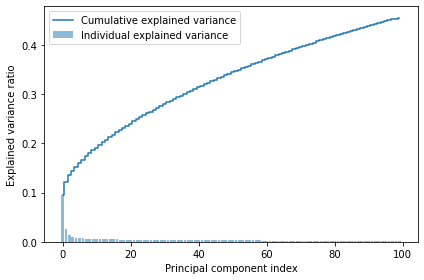

nested_score: 
[0.51567797 0.59879206 0.54573935 0.47224813 0.53974359 0.5375
 0.49692982 0.54883513 0.56019122 0.55264271]
0.5368299978015771
0
274
features (PCA reduced): (986, 100)


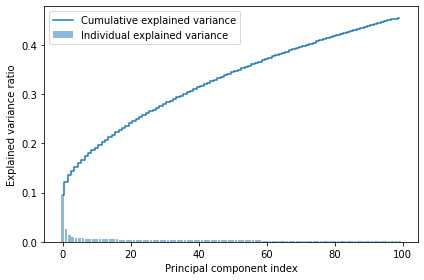

nested_score: 
[0.48166667 0.47916667 0.52081081 0.53951528 0.50621622 0.55004744
 0.43534247 0.49810606 0.51228632 0.57016317]
0.5093321099240817
1
274
features (PCA reduced): (986, 100)


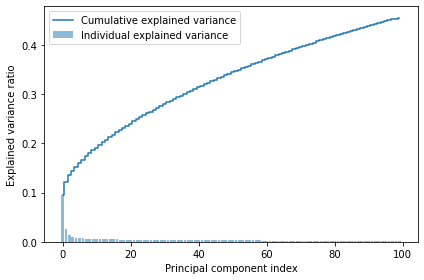

nested_score: 
[0.5        0.5        0.5        0.5        0.5        0.44805195
 0.5        0.48529412 0.5        0.48450855]
0.4917854612707554
2
604
features (PCA reduced): (986, 500)


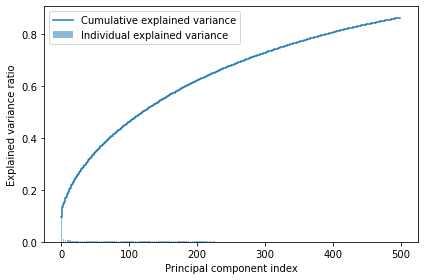

nested_score: 
[0.51610169 0.55759275 0.52443609 0.49323694 0.53461538 0.54017857
 0.52763158 0.52553763 0.52151239 0.5167019 ]
0.5257544935879568
0
274
features (PCA reduced): (986, 500)


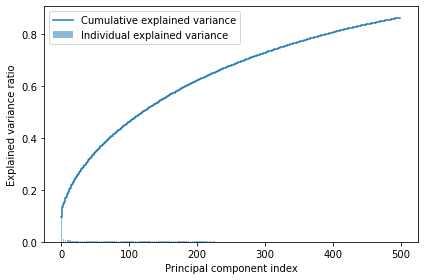

nested_score: 
[0.5        0.49305556 0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5       ]
0.49930555555555556
1
274
features (PCA reduced): (986, 500)


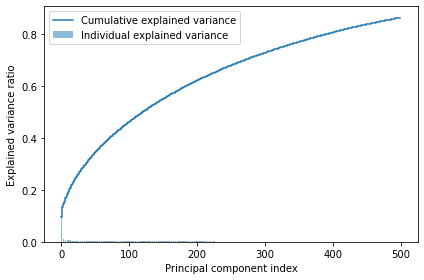

nested_score: 
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
0.5
2
604


ValueError: n_components=1000 must be between 0 and min(n_samples, n_features)=986 with svd_solver='full'

In [22]:
from sklearn import preprocessing
import scipy

y_shuff = nrem_dataframe["REPORT_BINARY_B"].copy().values
np.random.shuffle(y_shuff)

mean_accuracy_a = []
std_accuracy_a = []

mean_accuracy_b = []
std_accuracy_b = []

mean_accuracy_shuff = []
std_accuracy_shuff = []

for n_comp in [100,500,1000,2000]:
    
    y_iter = 0
    for y_test in [y_a,y_b,y_shuff]:
        print(np.sum(y_test))
        pca = PCA(n_components=n_comp)
        features_r = pca.fit(features_std).transform(features_std)
        print("features (PCA reduced): " + str(features_r.shape))

        # Determine explained variance using explained_variance_ration_ attribute
        #
        exp_var_pca = pca.explained_variance_ratio_
        #
        # Cumulative sum of eigenvalues; This will be used to create step plot
        # for visualizing the variance explained by each principal component.
        #
        cum_sum_eigenvalues = np.cumsum(exp_var_pca)
        #
        # Create the visualization plot
        #
        plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
        plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

    #     fig, axes = plt.subplots(figsize=(17,17))
    #     plt.imshow(features_r)
    #     plt.xlabel('Feature')
    #     plt.ylabel('Sample (Night)')
    #     plt.show()

        from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
        n_jobs = 50

        # Set up possible values of parameters to optimize over
        p_grid = {"C": [0.1, 1, 5, 10, 100, 500],
                  "gamma": [0.0001, 0.001,.01, .05, .1]}

        # We will use a Support Vector Classifier with "rbf" kernel
        svm = SVC(kernel="rbf",
                  class_weight="balanced")

        # Choose cross-validation techniques for the inner and outer loops,
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
        #     inner_cv = LeaveOneGroupOut()

        outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)
        #     outer_cv = LeaveOneGroupOut()

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=svm, 
                           param_grid=p_grid, 
                           scoring='balanced_accuracy',
                           cv=inner_cv,
                           refit=True)

        nested_score = cross_val_score(clf, 
                               X=features_r, 
                               y=y_test,
                               cv=outer_cv,
                               n_jobs=n_jobs,
        #                            groups=groups_ws,
                               scoring='balanced_accuracy') 

        print("nested_score: ")
        print(nested_score)
        print(nested_score.mean())

        print(y_iter)
        if y_iter == 0:
            mean_accuracy_a.append(nested_score.mean())
            std_accuracy_a.append(scipy.stats.sem(nested_score))
        
        elif y_iter == 1:
            mean_accuracy_b.append(nested_score.mean())
            std_accuracy_b.append(scipy.stats.sem(nested_score))
            
        else:
            mean_accuracy_shuff.append(nested_score.mean())
            std_accuracy_shuff.append(scipy.stats.sem(nested_score))
        
        
        y_iter = y_iter + 1

### Nice (Paper) Markers (Work in Progress)

In [197]:
# from nice import Markers
# from nice.markers import (PowerSpectralDensity,
#                           KolmogorovComplexity,
#                           PermutationEntropy,
#                           SymbolicMutualInformation,
#                           PowerSpectralDensitySummary,
#                           PowerSpectralDensityEstimator,
#                           ContingentNegativeVariation,
#                           TimeLockedTopography,
#                           TimeLockedContrast)

# raw = mne.io.read_raw_eeglab('/data/tvanasse/nccam3/sub-2000/eeg/ses-1/awakening-1-cleaned2_nrem.set')

# psuedo_events = np.array(range(int(raw.times[-1]*500-30*500), int(raw.times[-1])*500-(2*500), int(1.536*500)))

# events = np.zeros((len(psuedo_events), 3), dtype=np.int)
# events[:, 0] = psuedo_events
# events[:, 2] = 1  # ID of the event

# print(events)

# epochs = mne.Epochs(raw, events=events, event_id=1, tmin=-0.1, baseline=(None, 0),
#                     tmax=1.535, reject=None, picks=None, preload=True)



# # fname = '/data/tvanasse/nccam3/sub-2000/eeg/ses-1/awakening-1-cleaned2_nrem.set'
# # epochs = mne.read_epochs_eeglab('/data/tvanasse/nccam3/sub-2000/eeg/ses-1/awakening-1-cleaned2_nrem.set')

# psds_params = dict(n_fft=4096, n_overlap=100, n_jobs='auto', nperseg=128)

# base_psd = PowerSpectralDensityEstimator(
#     psd_method='welch', tmin=None, tmax=0.6, fmin=1., fmax=45.,
#     psd_params=psds_params, comment='default')

# # Note that the psd is shared by all `PowerSpectralDensity` markers.
# # To save time, the PSD will not be re-computed.
# # When making another set of marker, also recompute the base_psd explicitly.


# m_list = [
#     PowerSpectralDensity(estimator=base_psd, fmin=1., fmax=4.,
#                          normalize=False, comment='delta'),
#     PowerSpectralDensity(estimator=base_psd, fmin=1., fmax=4.,
#                          normalize=True, comment='deltan'),
#     PowerSpectralDensity(estimator=base_psd, fmin=4., fmax=8.,
#                          normalize=False, comment='theta'),
#     PowerSpectralDensity(estimator=base_psd, fmin=4., fmax=8.,
#                          normalize=True, comment='thetan'),
#     PowerSpectralDensity(estimator=base_psd, fmin=8., fmax=12.,
#                          normalize=False, comment='alpha'),
#     PowerSpectralDensity(estimator=base_psd, fmin=8., fmax=12.,
#                          normalize=True, comment='alphan'),
#     PowerSpectralDensity(estimator=base_psd, fmin=12., fmax=30.,
#                          normalize=False, comment='beta'),
#     PowerSpectralDensity(estimator=base_psd, fmin=12., fmax=30.,
#                          normalize=True, comment='betan'),
#     PowerSpectralDensity(estimator=base_psd, fmin=30., fmax=45.,
#                          normalize=False, comment='gamma'),
#     PowerSpectralDensity(estimator=base_psd, fmin=30., fmax=45.,
#                          normalize=True, comment='gamman'),

#     PowerSpectralDensity(estimator=base_psd, fmin=1., fmax=45.,
#                          normalize=True, comment='summary_se'),
#     PowerSpectralDensitySummary(estimator=base_psd, fmin=1., fmax=45.,
#                                 percentile=.5, comment='summary_msf'),
#     PowerSpectralDensitySummary(estimator=base_psd, fmin=1., fmax=45.,
#                                 percentile=.9, comment='summary_sef90'),
#     PowerSpectralDensitySummary(estimator=base_psd, fmin=1., fmax=45.,
#                                 percentile=.95, comment='summary_sef95'),

#     PermutationEntropy(tmin=None, tmax=1.5, backend='c'),

#     SymbolicMutualInformation(
#         tmin=None, tmax=0.6, method='weighted', backend='openmp',
#         method_params={'nthreads': 'auto'}, comment='weighted'),

#     KolmogorovComplexity(tmin=None, tmax=0.6, backend='openmp',
#                          method_params={'nthreads': 'auto'})
# ]

# mc = Markers(m_list)

# mc.fit(raw)

In [198]:
# psd = base_psd.data_
# freqs = base_psd.freqs_

# plt.figure()
# plt.semilogy(freqs, np.mean(psd, axis=0).T, alpha=0.1, color='black')
# plt.xlim(2, 40)
# plt.ylabel('log(psd)')
# plt.xlabel('Frequency [Hz]')

In [199]:
# picks = mne.io.pick.pick_types(epochs.info, meg=True, eeg=True)
# epochs.info

### Aquire Spectral Exponent Data

In [4]:
data_folder = '/data/tvanasse/nccam3/data/post_process_data/'
from scipy.io import loadmat
annots = loadmat(data_folder + 'spectral_slope_output.mat')

In [5]:
nrem_dataframe["SPECEXP_1-20_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_1-20"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_1-20_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["FREQ_1-20"] = np.array(0).astype('object') #create object for

nrem_dataframe["SPECEXP_20-40_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_20-40"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_20-40_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["FREQ_20-40"] = np.array(0).astype('object') #create object for 

nrem_dataframe["SPECEXP_1-40_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_1-40"] = np.array(0).astype('object') #create object for 
nrem_dataframe["OBS_1-40_ALL"] = np.array(0).astype('object') #create object for 
nrem_dataframe["FREQ_1-40"] = np.array(0).astype('object') #create object for 

# get spectral exponents & set timerange (1 or 2 minutes before awakening)
timerange = 1 # minutes before awakening
for i in range(0,annots['output'].shape[1]):
    print(i)
    if (str(annots['output']['freqrange'][0][i][0]) == '[20 40]') & (annots['output']['timerange'][0][i][0][0] == timerange):
        nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"SPECEXP_20-40"] = annots['output']['meanspectralexp'][0][i][0][0]
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"SPECEXP_20-40_ALL"] = annots['output']['spectralexp_all'][0][i][0].tolist()
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_20-40"] = annots['output']['obs_freq_avg'][0][i][0].tolist()
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_20-40_ALL"] = annots['output']['obs_freq_all'][0][i][0].tolist()
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"FREQ_20-40"] = annots['output']['freqbins'][0][i][0].tolist()
        
    elif (str(annots['output']['freqrange'][0][i][0]) == '[ 1 40]') & (annots['output']['timerange'][0][i][0][0] == timerange):
        nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"SPECEXP_1-40"] = annots['output']['meanspectralexp'][0][i][0][0]
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"SPECEXP_1-40_ALL"] = annots['output']['spectralexp_all'][0][i][0].tolist()
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-40"] = annots['output']['obs_freq_avg'][0][i][0].tolist()
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-40_ALL"] = annots['output']['obs_freq_all'][0][i][0].tolist()
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"FREQ_1-40"] = annots['output']['freqbins'][0][i][0].tolist()

    elif (str(annots['output']['freqrange'][0][i][0]) == '[ 1 20]') & (annots['output']['timerange'][0][i][0][0] == timerange):
        nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"SPECEXP_1-20"] = annots['output']['meanspectralexp'][0][i][0][0]
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"SPECEXP_1-20_ALL"] = annots['output']['spectralexp_all'][0][i][0].tolist()
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-20"] = annots['output']['obs_freq_avg'][0][i][0].tolist()
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-20_ALL"] = annots['output']['obs_freq_all'][0][i][0].tolist()
        nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"FREQ_1-20"] = annots['output']['freqbins'][0][i][0].tolist()

## FILTER OUT SUBJECTS WITHOUT REPORT/SOMETHING && NO REPORT
check = np.load('./sub_q1_data/sub_reportorsomethingandnoreport.npy')
print(check)
nrem_dataframe = nrem_dataframe[nrem_dataframe.ID.isin(check)].reset_index(drop=True)

nrem_dataframe["REPORT_BINARY"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"REPORT_BINARY"] = 1

nrem_dataframe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084


3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740


5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428


### Spectral Exponent (1-40) x 185 channels as feature matrix

In [ ]:
freqs = np.load("figures/freqs.npy")

time_before_awakening = 60

nrem_dataframe = pd.read_pickle("/data/tvanasse/nccam3/data/post_process_data/nrem_dataframe_psdextraction_" +\
                                str(time_before_awakening) + "s.pkl")

## FILTER OUT SUBJECTS WITHOUT REPORT/SOMETHING && NO REPORT
check = np.load('./sub_q1_data/sub_reportorsomethingandnoreport.npy')
print("Including subjects:")
print(check)
nrem_dataframe = nrem_dataframe[nrem_dataframe.ID.isin(check)].reset_index(drop=True)

nrem_dataframe["REPORT_BINARY"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,
                   "REPORT_BINARY"] = 1

nrem_dataframe["REPORT_BINARY_B"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] == "Report")].index,
                   "REPORT_BINARY_B"] = 1


# get band peaks
features_freqnorm = []
features_spatialnorm = []
features_absolute = []

for i in range(0,len(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values)):
#     print(i)
    x = []
    y = []
    z = []
        
    for f in [[0,4],[4,8],[8,13],[13,30],[30,50]]:
        a = np.where(freqs >= f[0])
        b = np.where(freqs <= f[1])
        c = np.intersect1d(a,b)
    
        # Spatial Normalization
        x.append(stats.zscore(np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1)))
#         print(np.array(x).shape)
#         plt.plot(stats.zscore(np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1)))
#         plt.show()

        # Normalize PSD value by sum of all frequencies
        y.append(np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1)/np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,:], axis=1))
#         print(np.array(y).shape)
#         plt.plot(np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1)/np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,:], axis=1))
#         plt.show()    

        # Mean PSD across band (ABSOLUTE)
        z.append(np.mean(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1))
    

    features_spatialnorm.append(np.array(x))
    features_freqnorm.append(np.array(y))
    features_absolute.append(np.array(z))
    
features_spatialnorm = np.array(features_spatialnorm)
features_freqnorm = np.array(features_freqnorm)
features_absolute = np.array(features_absolute)

In [7]:
# (n_samples, n_features) 
features = np.vstack(nrem_dataframe["SPECEXP_1-40_ALL"].values)
print("features: " + str(features.shape))

y = nrem_dataframe["REPORT_BINARY"].values
print("y: " + str(y.shape))

groups = nrem_dataframe["ID"].values
print("groups: " + str(groups.shape))

features: (986, 185)
y: (986,)
groups: (986,)


In [8]:
from sklearn import preprocessing
features = preprocessing.scale(features)

Text(0, 0.5, 'Sample (Night)')

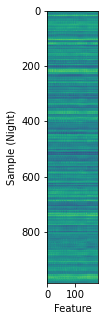

In [9]:
fig, axes = plt.subplots(figsize=(5,5))
plt.imshow(features)
plt.xlabel('Feature')
plt.ylabel('Sample (Night)')

In [10]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


n_splits = 10
n_jobs = 30

# # create group k fold with n splits
# gkf = GroupKFold(n_splits=n_splits)
# print(gkf)

# clf = svm.SVC(kernel='linear',
#               class_weight='balanced'
#              )

# print(cv_object)
# print("Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))

# clf = RandomForestClassifier(random_state=101)

#     # Set up possible values of parameters to optimize over
p_grid = {"C": [0.1, 1, 5, 10, 100],
          "gamma": [0.001,.01, .05, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf",
          class_weight="balanced")

# Choose cross-validation techniques for the inner and outer loops,
inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
#     inner_cv = LeaveOneGroupOut()

outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
#     outer_cv = LeaveOneGroupOut()

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=svm, 
                   param_grid=p_grid, 
                   scoring='balanced_accuracy',
                   cv=inner_cv,
                   refit=True)

nested_score = cross_val_score(clf, 
                       X=features, 
                       y=y,
                       cv=outer_cv,
                       n_jobs=n_jobs,
#                            groups=groups_ws,
                       scoring='balanced_accuracy') 

print("nested_score: ")
print(nested_score)
print(nested_score.mean())

nested_score: 
[0.53199153 0.51056946 0.54511278 0.48670709 0.52628205 0.66316964
 0.42587719 0.52419355 0.4928292  0.52452431]
0.5231256806457575


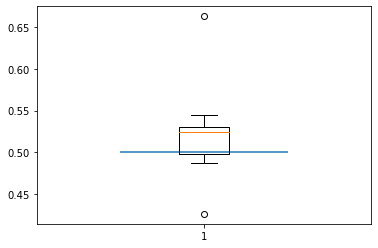

In [11]:
plt.boxplot(nested_score)
plt.hlines(0.5,0.75,1.25)

In [13]:
# rank features
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from matplotlib import cm, colors, colorbar

data_folder = "/data/tvanasse/nccam3/data/"
import mne
raw = mne.io.read_raw_eeglab(data_folder + 'sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.set')

from sklearn.feature_selection import RFECV

selector = RFECV(clf, 
                 step=features.shape[1]/10, 
                 cv=gkf, 
                 scoring='balanced_accuracy', 
                 verbose=0, 
                 n_jobs=n_jobs)
selector.fit(features, y, groups=groups)

plt.plot(selector.grid_scores_)
plt.show()

# Plot the topography of ranking
mne.viz.plot_topomap(selector.ranking_, 
                     raw.info, 
#                      vmin=1, 
#                      vmax=10, 
                     cmap=cm.viridis_r,)

Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt


NameError: name 'gkf' is not defined

In [58]:
# selector.estimator_.feature_importances_

In [128]:
# print("Fit to top features: " + str(features[:,selector.ranking_ == 1].shape))

# n_splits = 5

# # create group k fold with n splits
# gkf = GroupKFold(n_splits=n_splits)
# print(gkf)

# clf = svm.SVC(kernel='linear',
#               class_weight='balanced'
#              )

# cv_object = cross_validate(clf, 
#                            X=features[:,selector.ranking_ == 1], 
#                            y=y,
#                            cv=gkf,
#                            n_jobs=n_jobs,
#                            groups=groups,
#                            scoring='balanced_accuracy')

# print(cv_object)
# print("Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))

Fit to top features: (664, 5)
GroupKFold(n_splits=5)
{'fit_time': array([0.00771022, 0.00702167, 0.0068984 , 0.00808501, 0.00765657]), 'score_time': array([0.0022788 , 0.00233436, 0.00214887, 0.00230265, 0.00228238]), 'test_score': array([0.55992844, 0.41995991, 0.61564626, 0.53271693, 0.53503811])}
Mean Bal. Acc: 0.5326579299197418


In [60]:
import random
print(n_splits)
rand = []
for i in range(0,1000):
    print(i)
    random.shuffle(y)
    cv_object = cross_validate(clf, 
                               X=features, 
                               y=y,
                               cv=gkf,
                               n_jobs=n_jobs,
                               groups=groups,
                               scoring='balanced_accuracy')

    print("Null Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))
    rand.append(np.mean(cv_object['test_score']))

3
0
Null Mean Bal. Acc: 0.4944895733832686
1
Null Mean Bal. Acc: 0.5487340758318845
2
Null Mean Bal. Acc: 0.5152022592790706
3
Null Mean Bal. Acc: 0.5474035820289814
4
Null Mean Bal. Acc: 0.5000878027647881
5
Null Mean Bal. Acc: 0.500682894609762
6
Null Mean Bal. Acc: 0.48957145117193795
7
Null Mean Bal. Acc: 0.487107714716136
8
Null Mean Bal. Acc: 0.4653273079271136
9
Null Mean Bal. Acc: 0.4870680344374097
10
Null Mean Bal. Acc: 0.5099709070047405
11
Null Mean Bal. Acc: 0.513008220938716
12
Null Mean Bal. Acc: 0.5436544167784398
13
Null Mean Bal. Acc: 0.49425067392076655
14
Null Mean Bal. Acc: 0.4768377180506343
15
Null Mean Bal. Acc: 0.4819937222612895
16
Null Mean Bal. Acc: 0.4891968854435262
17
Null Mean Bal. Acc: 0.5049284841324478
18
Null Mean Bal. Acc: 0.47414305558012165
19
Null Mean Bal. Acc: 0.5011468108158369
20
Null Mean Bal. Acc: 0.5144892685118414
21
Null Mean Bal. Acc: 0.4947610533790226
22
Null Mean Bal. Acc: 0.48267207119204664
23
Null Mean Bal. Acc: 0.5137014611268641

Null Mean Bal. Acc: 0.4917012596968478
194
Null Mean Bal. Acc: 0.4945086206394933
195
Null Mean Bal. Acc: 0.48717924996561335
196
Null Mean Bal. Acc: 0.5045131340017363
197
Null Mean Bal. Acc: 0.5000598752021714
198
Null Mean Bal. Acc: 0.49260132287672037
199
Null Mean Bal. Acc: 0.4868633580616066
200
Null Mean Bal. Acc: 0.5163956191713068
201
Null Mean Bal. Acc: 0.4828502452380159
202
Null Mean Bal. Acc: 0.5354324122195283
203
Null Mean Bal. Acc: 0.4677802378382867
204
Null Mean Bal. Acc: 0.5069824504608403
205
Null Mean Bal. Acc: 0.48867611816923057
206
Null Mean Bal. Acc: 0.4895446673625181
207
Null Mean Bal. Acc: 0.49218249778498224
208
Null Mean Bal. Acc: 0.47931623566069453
209
Null Mean Bal. Acc: 0.5109821745298593
210
Null Mean Bal. Acc: 0.5017904732400581
211
Null Mean Bal. Acc: 0.5141307754840364
212
Null Mean Bal. Acc: 0.4972114872001301
213
Null Mean Bal. Acc: 0.496789189653563
214
Null Mean Bal. Acc: 0.47084698269020836
215
Null Mean Bal. Acc: 0.5031088612512252
216
Null M

Null Mean Bal. Acc: 0.48760959220906946
384
Null Mean Bal. Acc: 0.48591582015069185
385
Null Mean Bal. Acc: 0.4842989005417048
386
Null Mean Bal. Acc: 0.5125261324628992
387
Null Mean Bal. Acc: 0.49408291868443427
388
Null Mean Bal. Acc: 0.4932613845078646
389
Null Mean Bal. Acc: 0.5091018878897136
390
Null Mean Bal. Acc: 0.4996839635648596
391
Null Mean Bal. Acc: 0.49115447469519385
392
Null Mean Bal. Acc: 0.497497466442041
393
Null Mean Bal. Acc: 0.47750372964464805
394
Null Mean Bal. Acc: 0.48577726227050566
395
Null Mean Bal. Acc: 0.4787350740444382
396
Null Mean Bal. Acc: 0.49658526177128226
397
Null Mean Bal. Acc: 0.5119476414277153
398
Null Mean Bal. Acc: 0.48003930405916106
399
Null Mean Bal. Acc: 0.4751267505650925
400
Null Mean Bal. Acc: 0.4640608002732602
401
Null Mean Bal. Acc: 0.5186372826784087
402
Null Mean Bal. Acc: 0.4926969318759216
403
Null Mean Bal. Acc: 0.5020354517681996
404
Null Mean Bal. Acc: 0.5154631470465306
405
Null Mean Bal. Acc: 0.512163889575199
406
Null 

Null Mean Bal. Acc: 0.4756819164696244
574
Null Mean Bal. Acc: 0.48573163579348827
575
Null Mean Bal. Acc: 0.4971200617347984
576
Null Mean Bal. Acc: 0.5079351575494185
577
Null Mean Bal. Acc: 0.47624162982918605
578
Null Mean Bal. Acc: 0.49208926077417425
579
Null Mean Bal. Acc: 0.5467167558110398
580
Null Mean Bal. Acc: 0.504943489200001
581
Null Mean Bal. Acc: 0.48825869690368506
582
Null Mean Bal. Acc: 0.533393394501688
583
Null Mean Bal. Acc: 0.493529290301431
584
Null Mean Bal. Acc: 0.5264679133316343
585
Null Mean Bal. Acc: 0.5185364033630963
586
Null Mean Bal. Acc: 0.5093033062280433
587
Null Mean Bal. Acc: 0.5036057914675319
588
Null Mean Bal. Acc: 0.523106619162101
589
Null Mean Bal. Acc: 0.49839514596923
590
Null Mean Bal. Acc: 0.4960759897267238
591
Null Mean Bal. Acc: 0.5182682895119227
592
Null Mean Bal. Acc: 0.5147580404630034
593
Null Mean Bal. Acc: 0.4701157678029861
594
Null Mean Bal. Acc: 0.509453093661969
595
Null Mean Bal. Acc: 0.4981676256614607
596
Null Mean Bal.

KeyboardInterrupt: 

0.5468366253314656


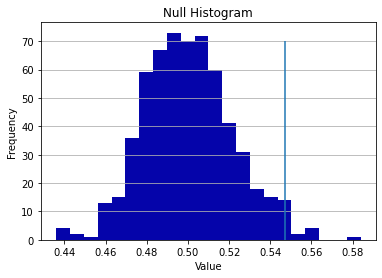

In [63]:
n, bins, patches = plt.hist(x=np.array(rand), bins='auto', color='#0504aa')
plt.grid(axis='y')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Null Histogram')
plt.vlines(0.547, 0,70)

threshold = np.percentile(np.array(rand), 97.5)
print(threshold)

features: (278, 185)
y: (278,)
groups: (278,)
features: (278, 185)


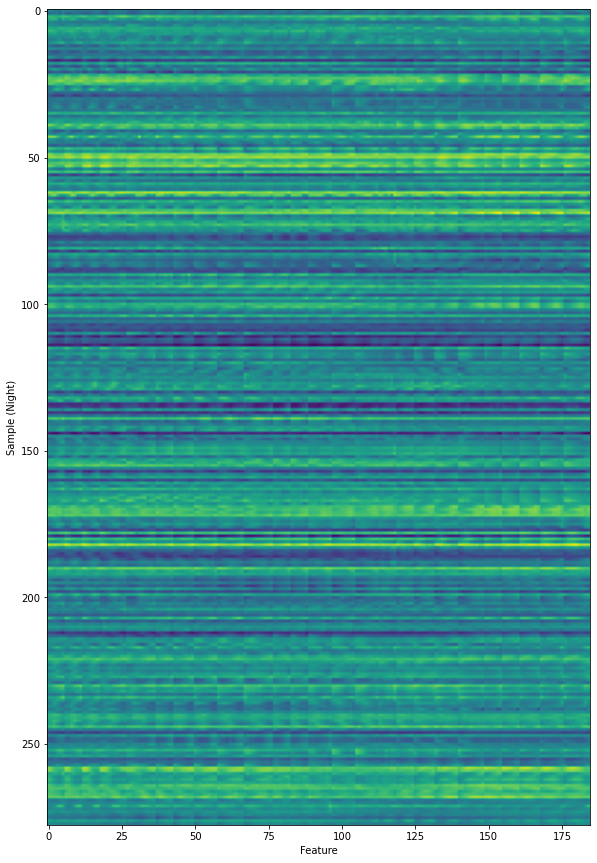

In [83]:
report_nrem_dataframe = nrem_dataframe[(nrem_dataframe["Q1Experience"] == "Report") &\
                                      (nrem_dataframe["Q6"].isnull() == False)]
report_nrem_dataframe = report_nrem_dataframe.reset_index(drop=True)


# (n_samples, n_features) 
features = np.vstack(report_nrem_dataframe["SPECEXP_1-40_ALL"].values)
print("features: " + str(features.shape))

from sklearn import preprocessing
features = preprocessing.scale(features)

y = report_nrem_dataframe["Q6"].values
print("y: " + str(y.shape))

groups = report_nrem_dataframe["ID"].values
print("groups: " + str(groups.shape))

print("features: " + str(features.shape))

fig, axes = plt.subplots(figsize=(10,15))
plt.imshow(features)
plt.xlabel('Feature')
plt.ylabel('Sample (Night)')

import optunity
import optunity.metrics
import sklearn.svm
import sklearn

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=features, y=y, num_folds=5, num_iter=2)
def svm_mse(x_train, y_train, x_test, y_test, C, gamma):
    model = sklearn.svm.SVR(C=C, gamma=gamma).fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return optunity.metrics.mse(y_test, y_pred)

# perform tuning
optimal_pars, _, _ = optunity.minimize(svm_mse, num_evals=100, C=[0, 10], gamma=[0, 1])

# train model on the full training set with tuned hyperparameters
optimal_model = sklearn.svm.SVR(**optimal_pars).fit(features, y)




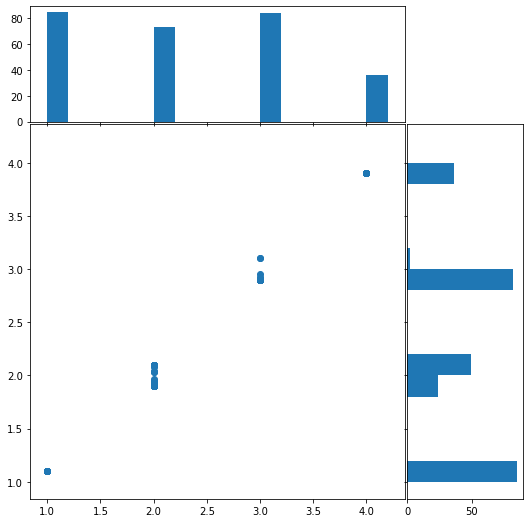

In [88]:
import numpy as np
import matplotlib.pyplot as plt


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.2
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    binsx = np.arange(1, lim + binwidth, binwidth)
    binsy = np.arange(1, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=binsx)
    ax_histy.hist(y, bins=binsy, orientation='horizontal')
    
    
# plt.scatter(y,optimal_model.predict(features))


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(y, optimal_model.predict(features), ax, ax_histx, ax_histy)


# plt.ylabel("Predicted Richness/Complexity")
# plt.xlabel("Actual Richness/Complexity")
# plt.title("Support Vector Regression of " + str(len(y)) + " Reports")
# # plt.show()

In [89]:
print(sklearn.metrics.r2_score(y, optimal_model.predict(features)))

n_splits = 3

# create group k fold with n splits
gkf = GroupKFold(n_splits=n_splits)
print(gkf)

cv_object = cross_validate(optimal_model, 
                           X=features, 
                           y=y,
                           cv=gkf,
                           n_jobs=n_jobs,
                           groups=groups,
                           scoring='r2')

print(cv_object)
print(np.mean(cv_object['test_score']))

0.9908218643111484
GroupKFold(n_splits=3)
{'fit_time': array([0.00506592, 0.00505304, 0.00514674]), 'score_time': array([0.00295115, 0.00288272, 0.00279427]), 'test_score': array([-0.05392044,  0.01349576, -0.19496401])}
-0.07846289443577532


### Classic frequency band peaks of 185 channels

In [37]:
# features = features_freqnorm.reshape(features_freqnorm.shape[0],5*185)
features = features_absolute.reshape(features_absolute.shape[0],5*185)

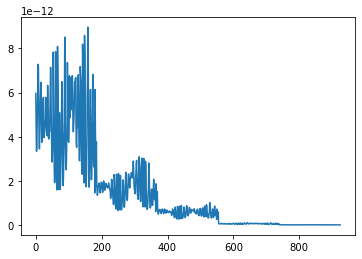

In [38]:
plt.plot(features[0])

y: (986,)
groups: (986,)
features: (986, 925)


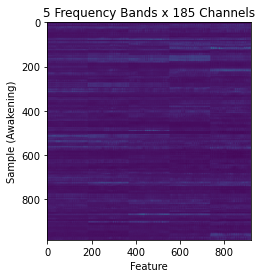

In [39]:
from sklearn import preprocessing
features = preprocessing.scale(features)

nrem_dataframe["REPORT_BINARY"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"REPORT_BINARY"] = 1

y = nrem_dataframe["REPORT_BINARY"].values
print("y: " + str(y.shape))

groups = nrem_dataframe["ID"].values
print("groups: " + str(groups.shape))

print("features: " + str(features.shape))

# fig, axes = plt.subplots(figsize=(10,15))
plt.imshow(features)
plt.xlabel('Feature')
plt.ylabel('Sample (Awakening)')
plt.title('5 Frequency Bands x 185 Channels')
plt.savefig("figures/features_5x185.png",dpi=350)

In [40]:
#     # Set up possible values of parameters to optimize over
p_grid = {"C": [0.1, 1, 5, 10, 100, 500],
          "gamma": [0.0001, 0.001,.01, .05, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf",
          class_weight="balanced")

# Choose cross-validation techniques for the inner and outer loops,
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
#     inner_cv = LeaveOneGroupOut()

outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)
#     outer_cv = LeaveOneGroupOut()

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=svm, 
                   param_grid=p_grid, 
                   scoring='balanced_accuracy',
                   cv=inner_cv,
                   refit=True)

nested_score = cross_val_score(clf, 
                       X=features, 
                       y=y,
                       cv=outer_cv,
                       n_jobs=n_jobs,
#                            groups=groups_ws,
                       scoring='balanced_accuracy') 

print("nested_score: ")
print(nested_score)
print(nested_score.mean())

nested_score: 
[0.56398305 0.56794651 0.55576441 0.54034515 0.48012821 0.69174107
 0.52587719 0.51702509 0.54454585 0.57906977]
0.5566426292954464


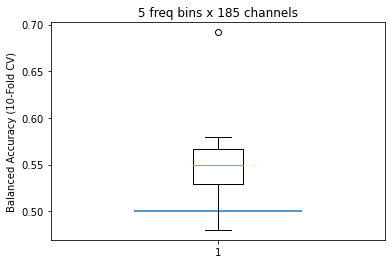

In [43]:
# fig, axes = plt.subplots(figsize=(5,4))
plt.boxplot(nested_score)
plt.hlines(0.5,0.75,1.25)
plt.ylabel("Balanced Accuracy (10-Fold CV)")
plt.title("5 freq bins x 185 channels")
plt.savefig("figures/accuracy_5x185.png",dpi=350)

In [83]:
optmized = clf.fit(features,y)
optmized.best_estimator_

NameError: name 'optimized' is not defined

In [81]:
svm = SVC(kernel="rbf",
          C=100,
          gamma = 0.001,
          class_weight="balanced")

In [82]:
clf.fit(features, y)

# rank features
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from matplotlib import cm, colors, colorbar

from sklearn.feature_selection import RFECV

selector = RFECV(svm, 
                 step=features.shape[1]/50, 
                 cv=outer_cv, 
                 scoring='balanced_accuracy', 
                 verbose=0, 
                 n_jobs=20)

selector = selector.fit(features, 
                        y)

plt.plot(selector.grid_scores_)
plt.ylabel('Accuracy')
plt.title('Recursive Feature Elimination')
plt.show()

ValueError: when `importance_getter=='auto'`, the underlying estimator SVC should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

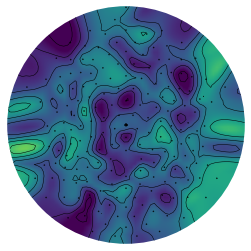

(<matplotlib.image.AxesImage at 0x7f16b0fad6d8>,
 <matplotlib.contour.QuadContourSet at 0x7f16b0fad9e8>)

In [68]:
channel_sum_ranking = []
for i in range(0,925,5):
    channel_sum_ranking.append(np.sum(selector.ranking_[i:i+5]))
    
# Plot the topography of ranking
mne.viz.plot_topomap(np.array(channel_sum_ranking), 
                     raw.info, 
                     vmin=1, 
                     vmax=200, 
                     cmap=cm.viridis_r,)

In [71]:
feat_cols = [ 'pixel'+str(i) for i in range(features.shape[1]) ]
df = pd.DataFrame(features,columns=feat_cols)
df['label'] = nrem_dataframe["ID"].values
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (847, 926)


In [72]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 847 samples in 0.001s...
[t-SNE] Computed neighbors for 847 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 847 / 847
[t-SNE] Mean sigma: 0.460131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.716702
[t-SNE] KL divergence after 300 iterations: 1.048790
t-SNE done! Time elapsed: 1.0400190353393555 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

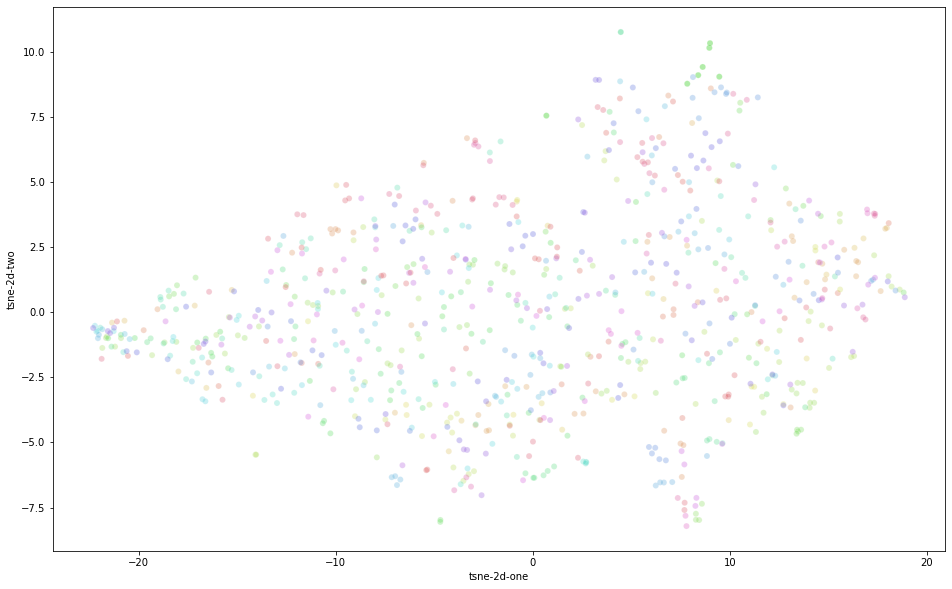

In [76]:
import seaborn as sns

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", len(pd.unique(df["label"]))),
#     palette=sns.color_palette("Spectral", as_cmap=True),
    data=df,
#     legend="full",
    legend=False,
    alpha=0.3
)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

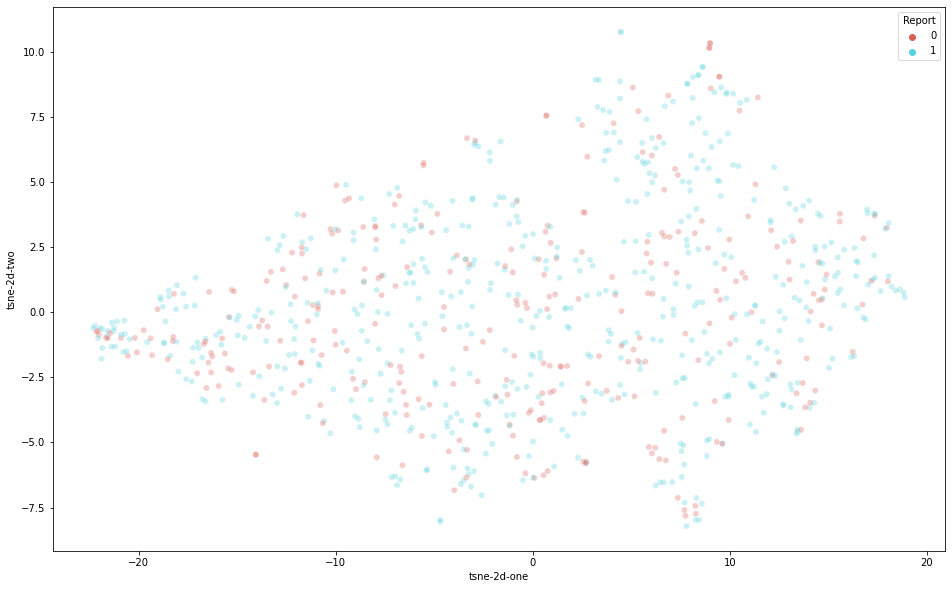

In [74]:
df['Report'] = nrem_dataframe["REPORT_BINARY"].values

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Report",
    palette=sns.color_palette("hls", 2),
#     palette=sns.color_palette("Spectral", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

### Report Only SVR

In [104]:
report_nrem_dataframe = nrem_dataframe[(nrem_dataframe["Q1Experience"] == "Report") &\
                                      (nrem_dataframe["Q6"].isnull() == False)]
report_nrem_dataframe = report_nrem_dataframe.reset_index(drop=True)

In [105]:
# get band peaks
features = []
for i in range(0,len(report_nrem_dataframe['PSDS_60SEC_1TO50HZ'].values)):
    print(i)
#     features.append(np.hstack(nrem_dataframe["OBS_1-40_ALL"].values[i]))
    y = []
        
    for f in [[0,4],[4,8],[8,13],[13,30],[30,50]]:
#     for f in [[30,50]]:
        a = np.where(freqs >= f[0])
        b = np.where(freqs <= f[1])
        c = np.intersect1d(a,b)
        
#         y.append(np.average(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1))
        
        y.append(np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1)/np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,:], axis=1))
            
    features.append(np.array(y).flatten('F'))
    
features = np.array(features)

print("features: " + str(features.shape))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

y: (329,)
groups: (329,)
features: (329, 925)


Text(0, 0.5, 'Sample (Night)')

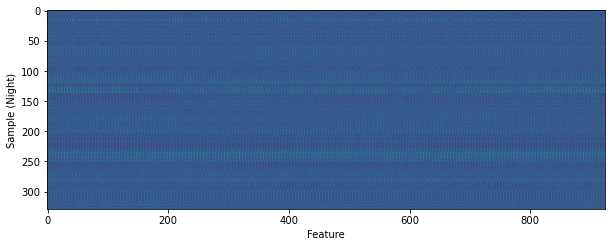

In [106]:
from sklearn import preprocessing
features = preprocessing.scale(features)

y = report_nrem_dataframe["Q6"].values
print("y: " + str(y.shape))

groups = report_nrem_dataframe["ID"].values
print("groups: " + str(groups.shape))

print("features: " + str(features.shape))

fig, axes = plt.subplots(figsize=(10,15))
plt.imshow(features)
plt.xlabel('Feature')
plt.ylabel('Sample (Night)')



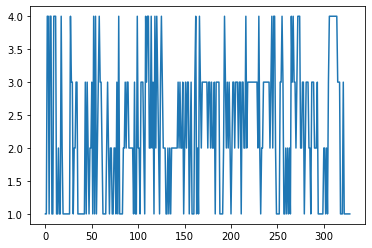

In [107]:
plt.plot(y)
plt.show()

In [108]:
features.shape

(329, 925)

In [109]:
import optunity
import optunity.metrics
import sklearn.svm
import sklearn

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=features, y=y, num_folds=5, num_iter=2)
def svm_mse(x_train, y_train, x_test, y_test, C, gamma):
    model = sklearn.svm.SVR(C=C, gamma=gamma).fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return optunity.metrics.mse(y_test, y_pred)

# perform tuning
optimal_pars, _, _ = optunity.minimize(svm_mse, num_evals=100, C=[0, 10], gamma=[0, 1])

# train model on the full training set with tuned hyperparameters
optimal_model = sklearn.svm.SVR(**optimal_pars).fit(features, y)


In [110]:
optimal_pars

{'C': 0.2921874999999996, 'gamma': 0.8128196539245638}

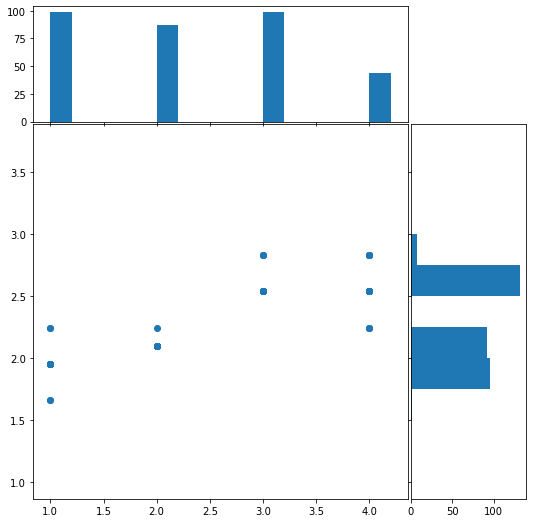

In [112]:
import numpy as np
import matplotlib.pyplot as plt


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.2
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    binsx = np.arange(1, lim + binwidth, binwidth)
    binsy = np.arange(1, 4, 0.25)
    ax_histx.hist(x, bins=binsx)
    ax_histy.hist(y, bins=binsy, orientation='horizontal')
    
    
# plt.scatter(y,optimal_model.predict(features))


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(y, optimal_model.predict(features), ax, ax_histx, ax_histy)


# plt.ylabel("Predicted Richness/Complexity")
# plt.xlabel("Actual Richness/Complexity")
# plt.title("Support Vector Regression of " + str(len(y)) + " Reports")
# # plt.show()

In [113]:
sklearn.metrics.r2_score(y, optimal_model.predict(features))

0.4153897011177181

In [114]:
sklearn.metrics.r2_score(y, optimal_model.predict(features))

n_splits = 2

# create group k fold with n splits
gkf = GroupKFold(n_splits=n_splits)
print(gkf)

cv_object = cross_validate(optimal_model, 
                           X=features, 
                           y=y,
                           cv=gkf,
                           n_jobs=n_jobs,
                           groups=groups,
                           scoring='r2')

print(cv_object)
print(np.mean(cv_object['test_score']))

GroupKFold(n_splits=2)
{'fit_time': array([0.01769042, 0.01546955]), 'score_time': array([0.02359581, 0.02052712]), 'test_score': array([-0.01294156, -0.01183299])}
-0.012387272702464314


In [118]:
from sklearn.svm import SVR

#     # Set up possible values of parameters to optimize over
p_grid = {"C": [0.1, 1, 5, 10, 100, 500],
          "gamma": [0.0001, 0.001,.01, .1, .5]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVR(kernel="rbf")

# Choose cross-validation techniques for the inner and outer loops,
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
#     inner_cv = LeaveOneGroupOut()

outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)
#     outer_cv = LeaveOneGroupOut()

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=svm, 
                   param_grid=p_grid, 
                   scoring='r2',
                   cv=inner_cv,
                   refit=True)

nested_score = cross_val_score(clf, 
                       X=features, 
                       y=y,
                       cv=outer_cv,
                       n_jobs=n_jobs,
#                            groups=groups_ws,
                       scoring='r2') 

print("nested_score: ")
print(nested_score)
print(nested_score.mean())

nested_score: 
[-0.09432513 -0.1372582   0.00743689 -0.39292887 -0.04970458 -0.03520787
 -0.12030099 -0.24175021  0.01632939 -0.00400075]
-0.10517103259411967


### Subject-Specific Normalized Frequency Bands
binarize according to median of data

In [28]:
# get band peaks
features = []
for i in range(0,len(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values)):
    print(i)
#     features.append(np.hstack(nrem_dataframe["OBS_1-40_ALL"].values[i]))
    y = []
        
    for f in [[0,4],[4,8],[8,13],[13,30],[30,50]]:
        
        a = np.where(freqs >= f[0])
        b = np.where(freqs <= f[1])
        c = np.intersect1d(a,b)
        
        binar = np.average(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1) > np.average(np.array(nrem_dataframe['PSDS_AWAKENING_MEDIAN'][i])[:,c],axis=1)
        binar = 1*binar # boolean to integer
        y.append(binar)
        
        #         y.append(np.average(np.array(nrem_dataframe['PSDS_30SEC_1TO50HZ'][i])[:,c,:], axis=(1,2)) -
#                             np.average(np.array(nrem_dataframe['PSDS_ALL_MEDIAN'][i])[:,c],axis=1))
        
#         mne.viz.plot_topomap(y[-1], 
#                      pos=raw.info, 
#                      outlines='skirt',
# #                      mask=sig_mask,
#                      vmin=-50, 
#                      vmax=50, 
#                      show=True,
# #                      axes=axs[row,j],
# #                      cmap=cmap,
#                      res=150,
# #                              cbar_fmt='-%0.1f',
#                      )
                 
            #                  np.average(np.array(avg_median)[:,:,c], axis=(0,2)))  
            
    features.append(np.array(y).flatten('F'))
    
features = np.array(features)

print("features: " + str(features.shape))

KeyError: 'PSDS_30SEC_1TO50HZ'

Nights with all the same value: 1
1/0 Ratio: 0.6153939174073402


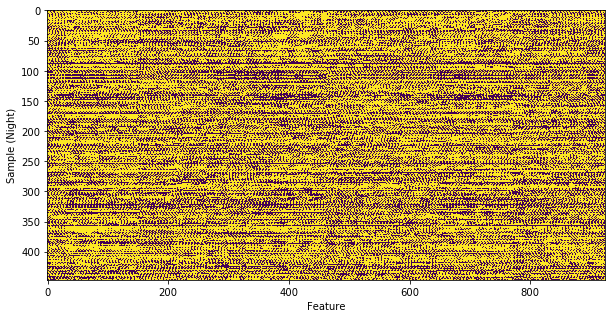

In [59]:
fig, axes = plt.subplots(figsize=(10,15))
plt.imshow(features)
plt.xlabel('Feature')
plt.ylabel('Sample (Night)')
# plt.colorbar()
# plt.show()

all_same = []
for i in range(0,features.shape[0]):
    # Check all values in an array are equal to its first element
    arr = features[i,:]
    result = np.all(arr == arr[0])
    if result == 1:
        all_same.append(i)

print("Nights with all the same value: " + str(len(all_same)))
print("1/0 Ratio: " + str(np.count_nonzero(features)/np.size(features)))

In [60]:
# from sklearn import preprocessing
# features = preprocessing.scale(features)

y = nrem_dataframe["REPORT_BINARY"].copy().values
print("y: " + str(y.shape))

groups = nrem_dataframe["ID"].values
print("groups: " + str(groups.shape))

print("features: " + str(features.shape))

y: (447,)
groups: (447,)
features: (447, 925)


In [61]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
from sklearn import svm 


n_splits = 3
n_jobs = 1

# create group k fold with n splits
gkf = GroupKFold(n_splits=n_splits)
print(gkf)

clf = svm.SVC(kernel='linear',
#               class_weight='balanced'
             )

# nonlinear svm model 
# clf = svm.NuSVC(gamma='auto')

cv_object = cross_validate(clf, 
                           X=features, 
                           y=y,
                           cv=gkf,
                           n_jobs=n_jobs,
                           groups=groups,
                           scoring='balanced_accuracy')

print(cv_object)
print("Mean: " + str(np.mean(cv_object['test_score'])))

GroupKFold(n_splits=3)
{'fit_time': array([0.01730585, 0.0207696 , 0.0287931 ]), 'score_time': array([0.00341392, 0.00344825, 0.00348902]), 'test_score': array([0.4791441 , 0.50803539, 0.50461957])}
Mean: 0.4972663507989595


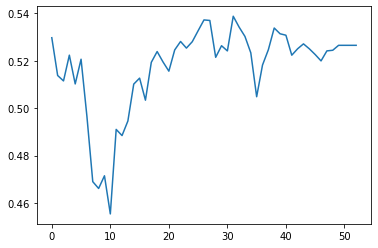

In [27]:
# rank features
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from matplotlib import cm, colors, colorbar

from sklearn.feature_selection import RFECV

selector = RFECV(clf, 
                 step=features.shape[1]/50, 
                 cv=gkf, 
                 scoring='balanced_accuracy', 
                 verbose=0, 
                 n_jobs=1)

selector = selector.fit(features, 
                        y, 
                        groups=groups)

plt.plot(selector.grid_scores_)
plt.show()

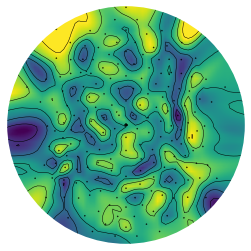

(<matplotlib.image.AxesImage at 0x7f5173fe4390>,
 <matplotlib.contour.QuadContourSet at 0x7f5173fe4690>)

In [28]:
channel_sum_ranking = []
for i in range(0,925,5):
    channel_sum_ranking.append(np.sum(selector.ranking_[i:i+5]))
    
# Plot the topography of ranking
mne.viz.plot_topomap(np.array(channel_sum_ranking), 
                     raw.info, 
#                      vmin=1, 
#                      vmax=100, 
                     cmap=cm.viridis_r,)

In [29]:
print("Fit to top features: " + str(features[:,selector.ranking_ == 1].shape))

n_splits = 5

# create group k fold with n splits
gkf = GroupKFold(n_splits=n_splits)
print(gkf)

clf = svm.SVC(kernel='linear',
              class_weight='balanced'
             )

cv_object = cross_validate(clf, 
                           X=features[:,selector.ranking_ == 1], 
                           y=y,
                           cv=gkf,
                           n_jobs=n_jobs,
                           groups=groups,
                           scoring='balanced_accuracy')

print(cv_object)
print("Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))

Fit to top features: (447, 547)
GroupKFold(n_splits=5)
{'fit_time': array([0.07990646, 0.08135581, 0.08227706, 0.08157992, 0.08304524]), 'score_time': array([0.01458025, 0.0143249 , 0.01438808, 0.01430321, 0.01472545]), 'test_score': array([0.7825    , 0.69064211, 0.8000516 , 0.60066741, 0.7677305 ])}
Mean Bal. Acc: 0.7283183229550418


Size of the dataframe: (447, 926)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 447 samples in 0.004s...
[t-SNE] Computed neighbors for 447 samples in 0.261s...
[t-SNE] Computed conditional probabilities for sample 447 / 447
[t-SNE] Mean sigma: 4.410073
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.287521
[t-SNE] KL divergence after 300 iterations: 1.726636
t-SNE done! Time elapsed: 1.0251922607421875 seconds


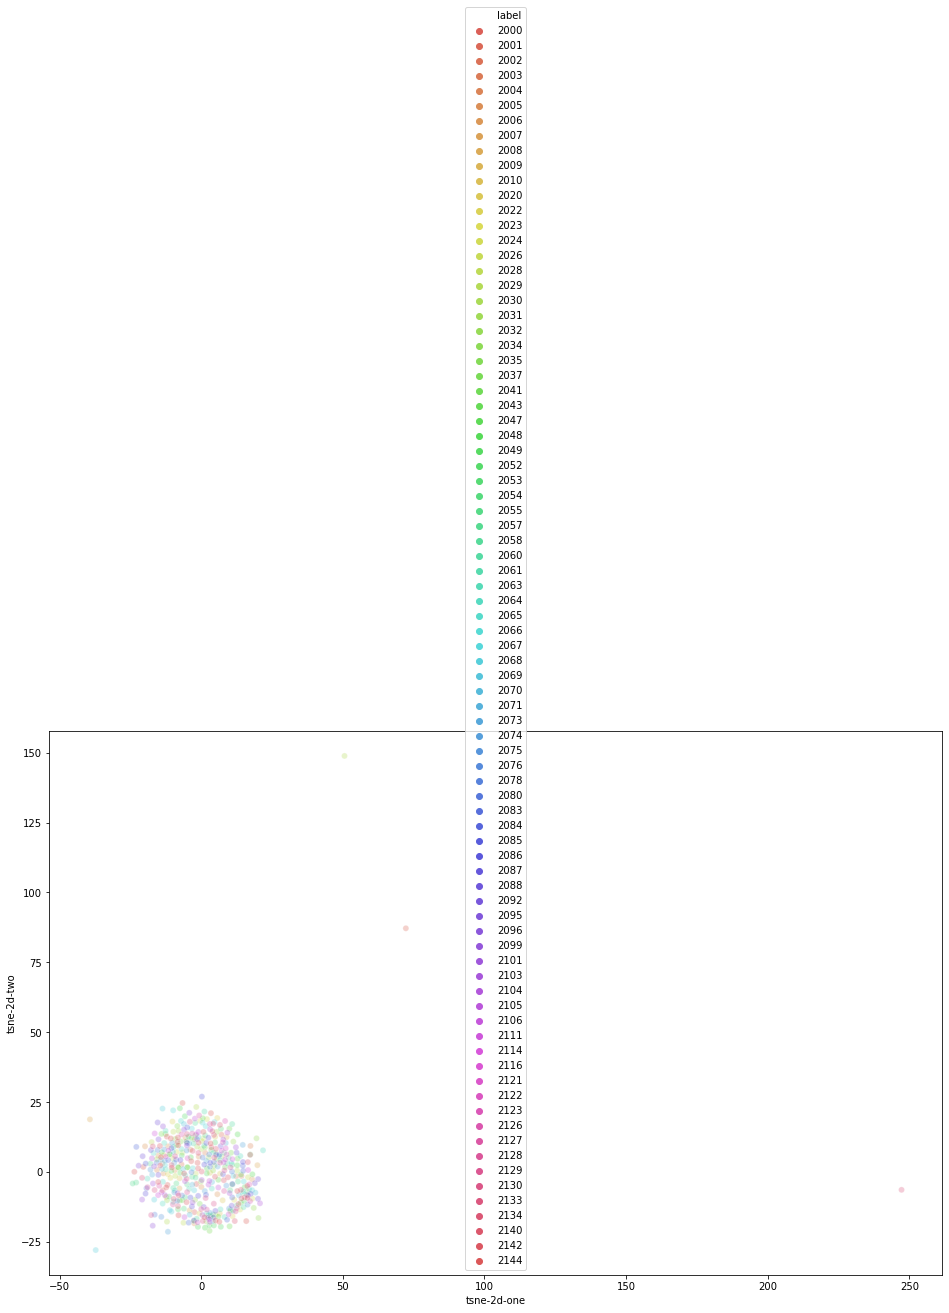

In [30]:
feat_cols = [ 'pixel'+str(i) for i in range(features.shape[1]) ]
df = pd.DataFrame(features,columns=feat_cols)
df['label'] = nrem_dataframe["ID"].values
print('Size of the dataframe: {}'.format(df.shape))

import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

import seaborn as sns

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", len(pd.unique(df["label"]))),
#     palette=sns.color_palette("Spectral", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

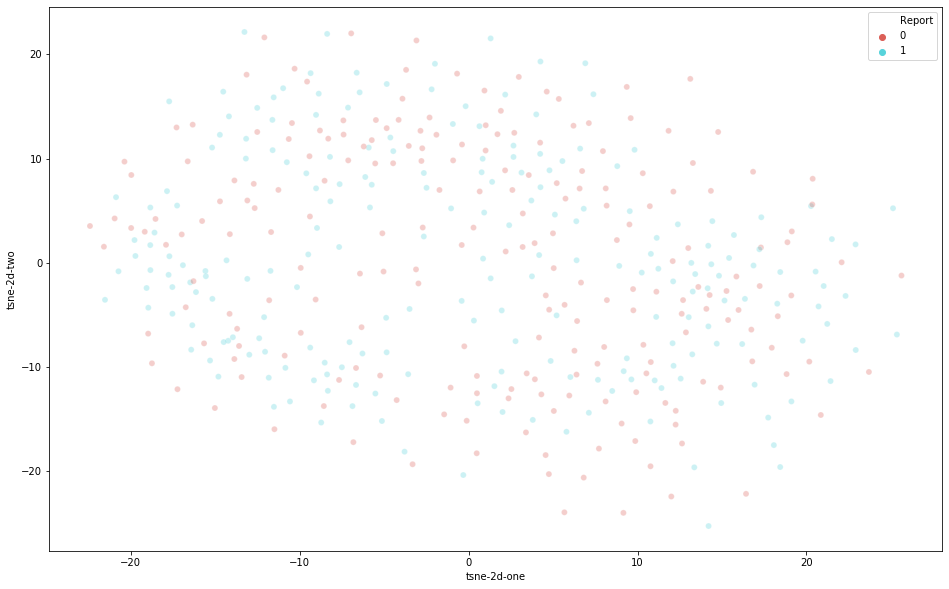

In [22]:
df['Report'] = nrem_dataframe["REPORT_BINARY"].values

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Report",
    palette=sns.color_palette("hls", 2),
#     palette=sns.color_palette("Spectral", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

In [26]:
import random
null_hist = []
n_splits = 3
n_jobs = 5

for i in range(0,50):
    
#     y = nrem_dataframe["REPORT_BINARY"].values
    random.shuffle(y)
    
    # create group k fold with n splits
    gkf = GroupKFold(n_splits=n_splits)

    clf = svm.SVC(kernel='linear',
                  class_weight='balanced'
                 )

#     selector = RFECV(clf, 
#                      step=features.shape[1]/10, 
#                      cv=gkf, 
#                      scoring='balanced_accuracy', 
#                      verbose=0, 
#                      n_jobs=n_jobs)

#     selector = selector.fit(features, 
#                             y, 
#                             groups=groups)
    
# #     plt.plot(selector.grid_scores_)
# #     plt.show()

    cv_object = cross_validate(clf, 
                               X=features[:,selector.ranking_ == 1], 
                               y=y,
                               cv=gkf,
                               n_jobs=n_jobs,
                               groups=groups,
                               scoring='balanced_accuracy')

    print("Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))
    null_hist.append(np.mean(cv_object['test_score']))

Mean Bal. Acc: 0.4944079069079068
Mean Bal. Acc: 0.49960380238280294
Mean Bal. Acc: 0.4763484767114854
Mean Bal. Acc: 0.5262052403155607
Mean Bal. Acc: 0.5053758395076757
Mean Bal. Acc: 0.47143874310420814
Mean Bal. Acc: 0.5343555635809157
Mean Bal. Acc: 0.4865450433677836
Mean Bal. Acc: 0.5020104740692982
Mean Bal. Acc: 0.5499718212601166
Mean Bal. Acc: 0.4920952861986565
Mean Bal. Acc: 0.4945408213681198
Mean Bal. Acc: 0.5445837375921794
Mean Bal. Acc: 0.4980687979353551
Mean Bal. Acc: 0.5209433037707368
Mean Bal. Acc: 0.48180031149773367
Mean Bal. Acc: 0.4965663021511479
Mean Bal. Acc: 0.5048525994099496
Mean Bal. Acc: 0.49093689963255177
Mean Bal. Acc: 0.48002463645019416
Mean Bal. Acc: 0.5000822280570564
Mean Bal. Acc: 0.4758950720907243
Mean Bal. Acc: 0.4852733033933328
Mean Bal. Acc: 0.5483712914595268
Mean Bal. Acc: 0.519364192556654
Mean Bal. Acc: 0.46451401607651616
Mean Bal. Acc: 0.5003024026507336
Mean Bal. Acc: 0.5535596126956736
Mean Bal. Acc: 0.49207107736172934
Mean Bal

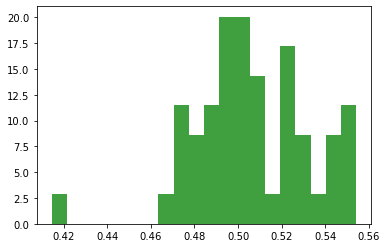

In [27]:
# the histogram of the data
n, bins, patches = plt.hist(np.array(null_hist), 20, density=True, facecolor='g', alpha=0.75)

### PSD of 185 channels--324 bins--as feature matrix

In [93]:
features = []
for i in range(0,len(nrem_dataframe["OBS_1-40_ALL"].values)):
    features.append(np.array(nrem_dataframe["OBS_1-40_ALL"].values[i]).flatten('F'))
features = np.vstack(np.array(features))

print("features: " + str(features.shape))

y = nrem_dataframe["REPORT_BINARY"].values
print("y: " + str(y.shape))

groups = nrem_dataframe["ID"].values
print("groups: " + str(groups.shape))

features: (847, 324)
y: (847,)
groups: (847,)


In [94]:
from sklearn import preprocessing
features = preprocessing.scale(features) # standardize each feature

In [96]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
from sklearn import svm 


n_splits = 3
n_jobs = 30

# create group k fold with n splits
gkf = GroupKFold(n_splits=n_splits)
print(gkf)

clf = svm.SVC(kernel='linear',
              class_weight='balanced'
             )

cv_object = cross_validate(clf, 
                           X=features, 
                           y=y,
                           cv=gkf,
                           n_jobs=n_jobs,
                           groups=groups,
                           scoring='balanced_accuracy')

cv_object



GroupKFold(n_splits=3)


{'fit_time': array([0.28181267, 0.21548033, 0.21201372]),
 'score_time': array([0.01190495, 0.01241279, 0.0137248 ]),
 'test_score': array([0.5043684 , 0.45826268, 0.46115288])}

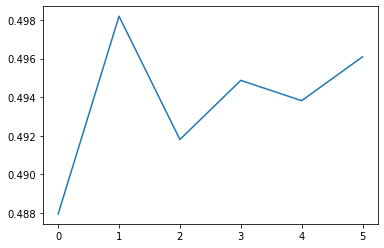

In [25]:
from sklearn.feature_selection import RFECV

selector = RFECV(clf, 
                 step=features.shape[1]/5, 
                 cv=gkf, 
                 scoring='balanced_accuracy', 
                 verbose=0, 
                 n_jobs=n_jobs)
selector = selector.fit(features, y, groups=groups)

plt.plot(selector.grid_scores_)

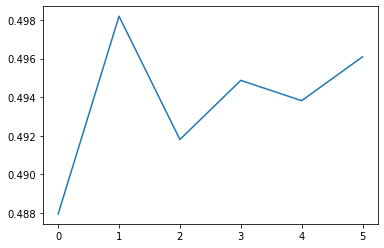

In [26]:
plt.plot(selector.grid_scores_)

In [27]:
selector.estimator_.

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
channel_sum_ranking = []
for i in range(0,59940,324):
    channel_sum_ranking.append(np.sum(selector.ranking_[i:i+324]))

In [ ]:
# Plot the topography of ranking
mne.viz.plot_topomap(np.array(channel_sum_ranking), 
                     raw.info, 
#                      vmin=1, 
#                      vmax=2, 
                     cmap=cm.viridis_r,)

In [ ]:
# create group k fold with n splits
gkf = GroupKFold(n_splits=n_splits)
print(gkf)

clf = svm.SVC(kernel='linear',
              class_weight='balanced'
             )

cv_object = cross_validate(clf, 
                           X=features[:,selector.ranking_ == 1], 
                           y=y,
                           cv=gkf,
                           n_jobs=n_jobs,
                           groups=groups,
                           scoring='balanced_accuracy')

print(cv_object)
print("Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))

### PSD of 185 channels--200 freq bins--as feature matrix (PCA REDUCED): 2-CLASS

features (PCA reduced): (986, 50)


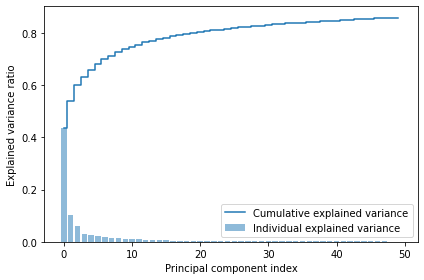

nested_score: 
[0.59300847 0.57614323 0.57706767 0.53964552 0.52948718 0.62433036
 0.63333333 0.52060932 0.53563668 0.6038055 ]
0.5733067258550035
features (PCA reduced): (986, 100)


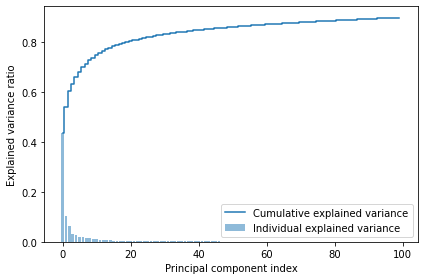

nested_score: 
[0.6184322  0.64020708 0.61779449 0.57765858 0.49551282 0.63861607
 0.61578947 0.51702509 0.53563668 0.61289641]
0.5869568887615106
features (PCA reduced): (986, 150)


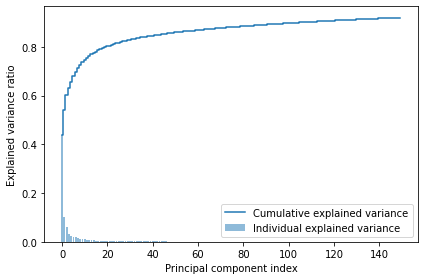

nested_score: 
[0.61440678 0.65336497 0.59711779 0.61357276 0.47884615 0.63080357
 0.60614035 0.54704301 0.56540635 0.61945032]
0.592615205423952
features (PCA reduced): (986, 200)


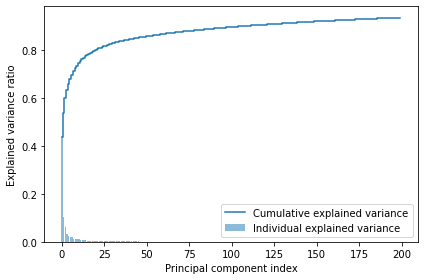

nested_score: 
[0.60190678 0.58261432 0.58834586 0.56809701 0.49294872 0.6671875
 0.60614035 0.54121864 0.53976532 0.58964059]
0.5777865100151273
features (PCA reduced): (986, 250)


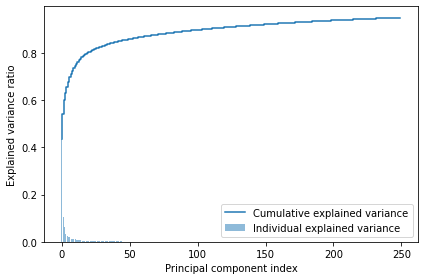

nested_score: 
[0.62288136 0.65660052 0.54385965 0.56063433 0.49294872 0.66852679
 0.60614035 0.55510753 0.57800956 0.57547569]
0.5860184480686801
features (PCA reduced): (986, 300)


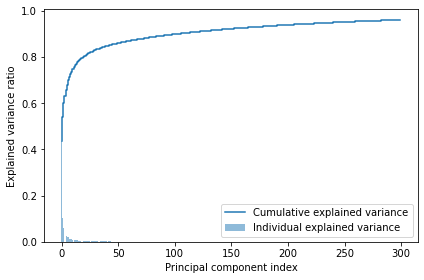

nested_score: 
[0.63135593 0.63028473 0.54949875 0.59864739 0.50961538 0.659375
 0.56666667 0.54928315 0.58648414 0.5820296 ]
0.5863240736388415
features (PCA reduced): (986, 350)


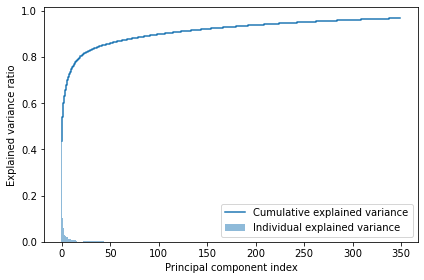

nested_score: 
[0.61885593 0.57765315 0.55827068 0.5755597  0.48717949 0.659375
 0.575      0.54928315 0.56953498 0.56786469]
0.5738576779190928
features (PCA reduced): (986, 400)


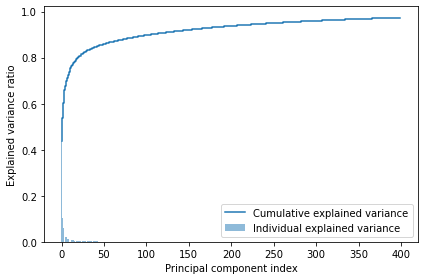

nested_score: 
[0.61885593 0.61712683 0.54072682 0.59048507 0.50384615 0.659375
 0.56184211 0.55734767 0.57800956 0.54460888]
0.5772224027263214
features (PCA reduced): (986, 450)


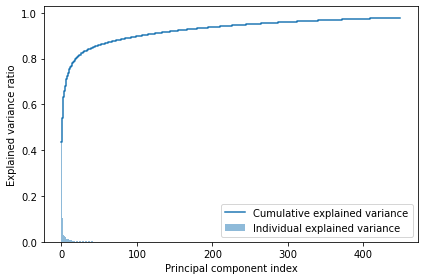

nested_score: 
[0.61885593 0.61712683 0.54949875 0.59794776 0.53461538 0.6671875
 0.56184211 0.57930108 0.57800956 0.54460888]
0.5848993779442092


Text(0.5, 0, 'Principal Components of\n 185 channels x 200 frequencies')

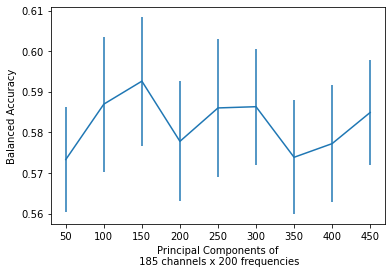

In [66]:
# fig, axes = plt.subplots(figsize=(5,4))
# plt.boxplot(nested_score)
# plt.hlines(0.5,0.75,1.25)
# plt.ylabel("Balanced Accuracy (10-Fold CV)")
# plt.title(str(n_comp) + " PCA Components of \n200 freq bins x 185 channels")
# plt.savefig("figures/accuracy_200x185pca" + str(n_comp) + ".png",dpi=350)

component weights, channel sum: 0


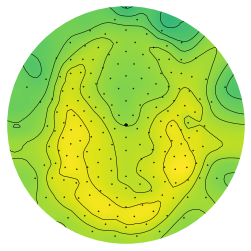

component weights, channel sum: 1


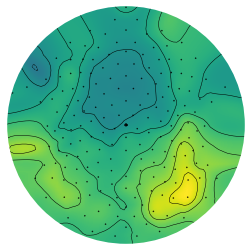

component weights, channel sum: 2


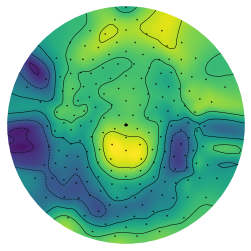

component weights, channel sum: 3


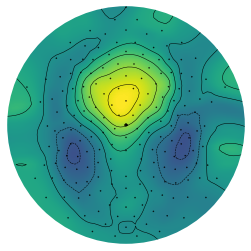

component weights, channel sum: 4


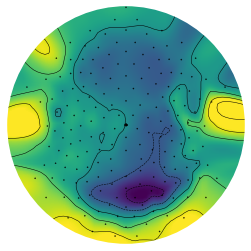

component weights, channel sum: 5


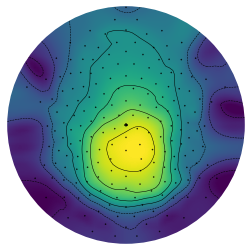

component weights, channel sum: 6


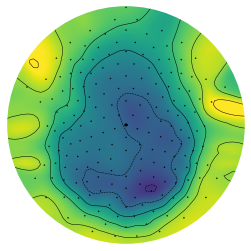

component weights, channel sum: 7


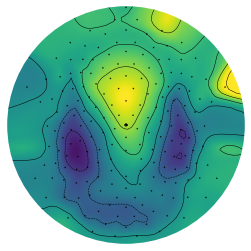

component weights, channel sum: 8


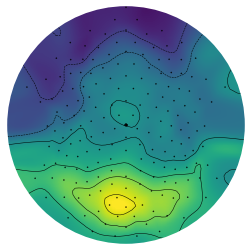

component weights, channel sum: 9


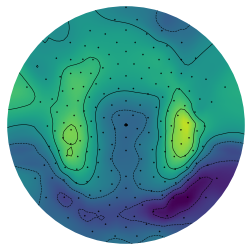

component weights, channel sum: 10


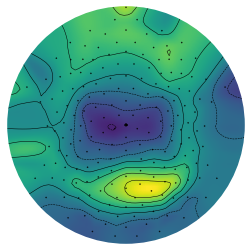

component weights, channel sum: 11


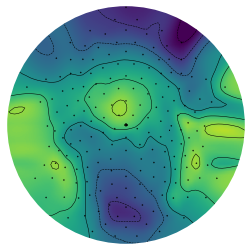

component weights, channel sum: 12


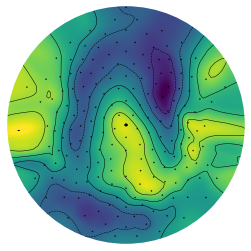

component weights, channel sum: 13


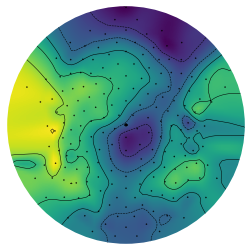

component weights, channel sum: 14


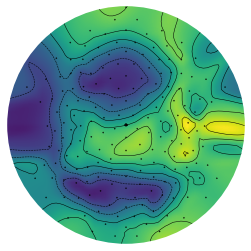

component weights, channel sum: 15


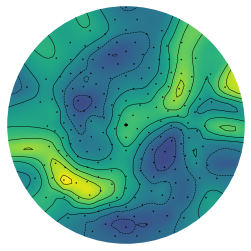

component weights, channel sum: 16


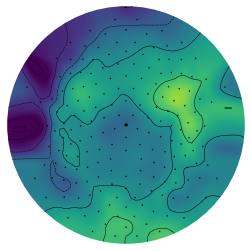

component weights, channel sum: 17


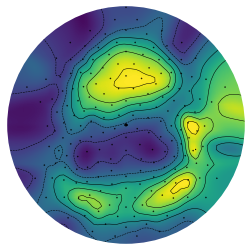

component weights, channel sum: 18


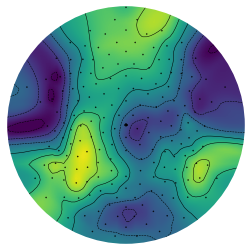

component weights, channel sum: 19


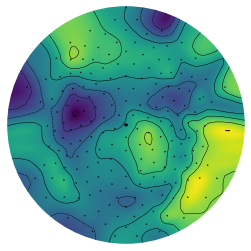

In [36]:
# from sklearn.model_selection import GroupKFold
# from sklearn.model_selection import cross_validate
# from sklearn import svm 

# # create group k fold with n splits
# gkf = GroupKFold(n_splits=n_splits)
# print(gkf)

# clf = svm.SVC(kernel='linear',
#               class_weight='balanced'
#              )

# from sklearn.feature_selection import RFECV
# n_jobs = 50
# selector = RFECV(clf, 
#                  step=features_r.shape[1]/10, 
#                  cv=gkf, 
#                  scoring='balanced_accuracy', 
#                  verbose=0, 
#                  n_jobs=5)

# selector = selector.fit(features_r, y, groups=groups)

# all_comp = []

# for comp in range(0,50):
# #     if (selector.ranking_[comp] == 1) or (selector.ranking_[comp] == 2) or (selector.ranking_[comp] == 3) :
#     if (selector.ranking_[comp] < 2):
#         print("component " + str(comp+1) + " sum of pca weights per channel")
#         print("feature ranking: " + str(selector.ranking_[comp]))
#         print("component weights, channel sum: " + str(comp))
#     #     print("feature ranking: " + str(selector.ranking_[comp]))
#         channel_sum_ranking = []
#         for i in range(0,185):
#     #         end_shape = np.array(nrem_dataframe["TF"].values[0]).shape
#             end_shape = (185, 200)
#             channel_sum_ranking.append(np.sum(np.abs(pca.components_[comp].reshape(end_shape, order='F')[i,:])))
#     #         channel_sum_ranking.append(np.sum(np.absolute(pca.components_[comp][i:i+324])))
#         # Plot the topography of ranking
        
#         ## ONLY FOR PLOTTING, MNE reads positions as meters
#         for i in range(len(raw.info['chs'])):
#             raw.info['chs'][i]['loc'] = raw.info['chs'][i]['loc']/100
    
#         mne.viz.plot_topomap(np.array(channel_sum_ranking), 
#                              raw.info, 
#         #                      vmin=1, 
#         #                      vmax=2, 
#                              cmap=cm.viridis,)
#         plt.show()
#         all_comp.append(np.array(channel_sum_ranking))
        
# raw = mne.io.read_raw_eeglab('/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.set')
# # Plot the topography of ranking

# ## ONLY FOR PLOTTING, MNE reads positions as meters
# for i in range(len(raw.info['chs'])):
#     raw.info['chs'][i]['loc'] = raw.info['chs'][i]['loc']/100
    
# mne.viz.plot_topomap(np.sum(np.abs(np.array(all_comp)),0), 
#                              raw.info, 
#         #                      vmin=1, 
#         #                      vmax=2, 
#                              cmap=cm.viridis,)
# plt.show()
        

In [69]:
## Searchlight

features (PCA reduced): (986, 150)


In [76]:
## get back-projected data from PCA, and reshape per 185 channels

(986, 150)
(986, 37000)
(986, 185, 200)


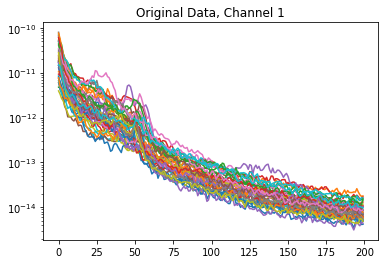

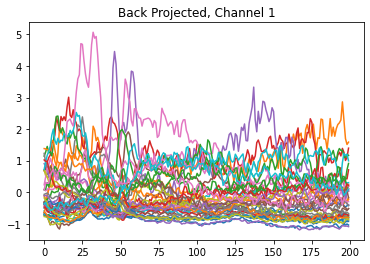

Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 185
1 is next to ['1', '2', '10', '219', '220', '221', '222']
[  0   1   9 179 180 181 182]
nested_score: 
[0.55508475 0.60094909 0.5802005  0.50163246 0.46282051 0.47879464
 0.55394737 0.5062724  0.49739244 0.58921776]
0.5326311926337008
2 is next to ['1', '2', '3', '10', '11', '222', '223']
[  0   1   2   9  10 182 183]
nested_score: 
[0.54300847 0.54680759 0.54072682 0.56273321 0.57179487 0.54375
 0.56798246 0.58646953 0.50564972 0.55179704]
0.5520719712995135
3 is next to ['2', '3', '4', '11', '223', '224']
[  1   2   3  10 183 184]
nested_score: 
[0.60995763 0.59275237 0.54887218 0.5545709  0.58012821 0.5984375
 0.51491228 0.59543011 0.48935246 0.54207188]
0.5626485506245034
4 is next to ['3', '4', '5', '11', '12', '13', '224']
[  2   3   4  10  11  12 184]
nested_s

KeyboardInterrupt: 

Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt


Text(0.5, 1.0, 'Searchlight Accuracy')

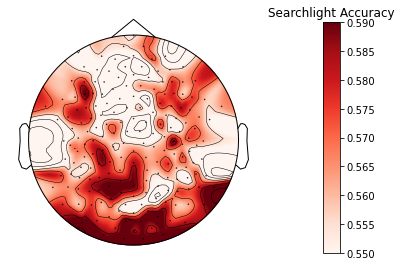

### Time-Frequency as Predictors (PCA reduced)

In [18]:
from sklearn.decomposition import PCA
import random

components = 50

features = []
for i in range(0,len(nrem_dataframe["TF"].values)):
    if len(np.array(nrem_dataframe["TF"].values[i]).shape) == 4:
        features.append(np.array(nrem_dataframe["TF"].values[i])[:,:,:,0].flatten('F')) # for some reason matlab spits out 
    else:
        features.append(np.array(nrem_dataframe["TF"].values[i]).flatten('F'))
        
features = np.vstack(np.array(features))

features: (664, 370000)
y: (664,)
groups: (664,)
0
3700
features (PCA reduced): (664, 50)


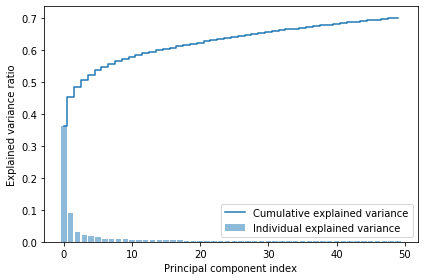

In [19]:
print("features: " + str(features.shape))
y = nrem_dataframe["REPORT_BINARY"].values

print("y: " + str(y.shape))

groups = nrem_dataframe["ID"].values
print("groups: " + str(groups.shape))

print(len(features[features == float('+inf')]))
features[features == float('+inf')] = 0
print(len(features[features == float('-inf')]))
features[features == float('-inf')] = 0

pca = PCA(n_components=components)
features_r = pca.fit(features).transform(features)

print("features (PCA reduced): " + str(features_r.shape))

# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [20]:
from sklearn import preprocessing
features_r = preprocessing.scale(features_r) # standardize each feature

In [21]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
from sklearn import svm 


n_splits = 3

n_jobs = 30

# create group k fold with n splits
gkf = GroupKFold(n_splits=n_splits)
print(gkf)

clf = svm.SVC(kernel='linear',
              class_weight='balanced'
             )

# clf = svm.NuSVC(gamma='auto')

cv_object = cross_validate(clf, 
                           X=features_r, 
                           y=y,
                           cv=gkf,
                           n_jobs=n_jobs,
                           groups=groups,
                           scoring='balanced_accuracy')

print(cv_object)
print("Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))

GroupKFold(n_splits=3)
{'fit_time': array([0.05696559, 0.04425812, 0.04876995]), 'score_time': array([0.00475264, 0.00512052, 0.00459027]), 'test_score': array([0.52729899, 0.5683272 , 0.50261525])}
Mean Bal. Acc: 0.5327471441153844


In [40]:
for i in range(0,10):
    random.shuffle(y)
    cv_object = cross_validate(clf, 
                               X=features_r, 
                               y=y,
                               cv=gkf,
                               n_jobs=n_jobs,
                               groups=groups,
                               scoring='balanced_accuracy')

    print("Null Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))

Null Mean Bal. Acc: 0.5411614440988033
Null Mean Bal. Acc: 0.4940797976409155


Exception ignored in: <function _releaseLock at 0x7fc8e2268560>
Traceback (most recent call last):
  File "/home/tvanasse/miniconda/envs/nsddata/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

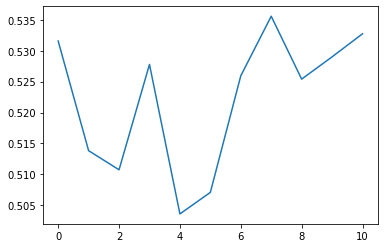

In [22]:
from sklearn.feature_selection import RFECV
n_jobs = 20
selector = RFECV(clf, 
                 step=features_r.shape[1]/10, 
                 cv=gkf, 
                 scoring='balanced_accuracy', 
                 verbose=0, 
                 n_jobs=5)

selector = selector.fit(features_r, y, groups=groups)

plt.plot(selector.grid_scores_)

Reading /data/tvanasse/nccam3/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
component 1 sum of pca weights per channel
feature ranking: 1


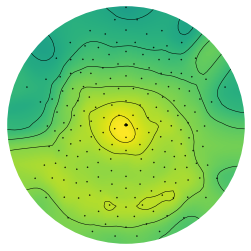

component 2 sum of pca weights per channel
feature ranking: 1


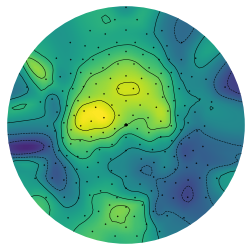

component 3 sum of pca weights per channel
feature ranking: 1


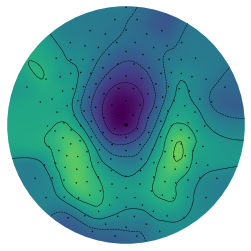

component 4 sum of pca weights per channel
feature ranking: 1


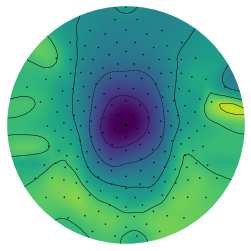

component 5 sum of pca weights per channel
feature ranking: 1


KeyboardInterrupt: 

In [27]:
import mne
raw = mne.io.read_raw_eeglab(data_folder + 'sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.set')

for comp in range(0,components):
#     if (selector.ranking_[comp] == 1) or (selector.ranking_[comp] == 2) or (selector.ranking_[comp] == 3) :
    if (selector.ranking_[comp] == 1):
        print("component " + str(comp+1) + " sum of pca weights per channel")
        print("feature ranking: " + str(selector.ranking_[comp]))
        channel_sum_ranking = []
        for i in range(0,185):
            end_shape = np.array(nrem_dataframe["TF"].values[0]).shape
            end_shape = (185, 20, 100)
            channel_sum_ranking.append(np.sum(pca.components_[comp].reshape(end_shape, order='F')[i,:,:]))
        # Plot the topography of ranking
        mne.viz.plot_topomap(np.array(channel_sum_ranking), 
                             raw.info, 
        #                      vmin=1, 
        #                      vmax=2, 
                             cmap=cm.viridis,)
        plt.show()

In [26]:
np.array(nrem_dataframe["TF"].values[0]).shape

(185, 20, 100, 2)

In [ ]:
print("Fit to top features: " + str(features_r[:,selector.ranking_ == 1].shape[1]))

n_splits=5

# create group k fold with n splits
gkf = GroupKFold(n_splits=n_splits)
print(gkf)

clf = svm.SVC(kernel='linear',
              class_weight='balanced'
             )

cv_object = cross_validate(clf, 
                           X=features_r[:,selector.ranking_ == 1], 
                           y=y,
                           cv=gkf,
                           n_jobs=n_jobs,
                           groups=groups,
                           scoring='balanced_accuracy')

print(cv_object)
print("Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))

In [108]:
## shuffled histogram

null_hist = []
n_splits = 3
n_jobs = 5

for i in range(0,50):
    
    y = nrem_dataframe["REPORT_BINARY"].values
    random.shuffle(y)
    
    # create group k fold with n splits
    gkf = GroupKFold(n_splits=n_splits)

    clf = svm.SVC(kernel='linear',
                  class_weight='balanced'
                 )

    selector = RFECV(clf, 
                     step=features_r.shape[1]/10, 
                     cv=gkf, 
                     scoring='balanced_accuracy', 
                     verbose=0, 
                     n_jobs=n_jobs)

    selector = selector.fit(features_r, 
                            y, 
                            groups=groups)
    
#     plt.plot(selector.grid_scores_)
#     plt.show()

    cv_object = cross_validate(clf, 
                               X=features_r[:,selector.ranking_ == 1], 
                               y=y,
                               cv=gkf,
                               n_jobs=n_jobs,
                               groups=groups,
                               scoring='balanced_accuracy')

    print("Mean Bal. Acc: " + str(np.mean(cv_object['test_score'])))
    null_hist.append(np.mean(cv_object['test_score']))

Mean Bal. Acc: 0.5315547939376346
Mean Bal. Acc: 0.5061203611203612
Mean Bal. Acc: 0.5185485906229715
Mean Bal. Acc: 0.5416299903799905
Mean Bal. Acc: 0.5376991651615618
Mean Bal. Acc: 0.5322779176789671
Mean Bal. Acc: 0.5292879102244543
Mean Bal. Acc: 0.5439359538393118
Mean Bal. Acc: 0.5406627966632725
Mean Bal. Acc: 0.5271037648657334
Mean Bal. Acc: 0.5744747287718558
Mean Bal. Acc: 0.5876026305325056
Mean Bal. Acc: 0.5449979336606828
Mean Bal. Acc: 0.5255158546171064
Mean Bal. Acc: 0.5427061666380967
Mean Bal. Acc: 0.5273623847034902
Mean Bal. Acc: 0.5098261373842448
Mean Bal. Acc: 0.55673477756168
Mean Bal. Acc: 0.5535579350317201
Mean Bal. Acc: 0.5516926171080802
Mean Bal. Acc: 0.5249760500585413
Mean Bal. Acc: 0.5211925115788061
Mean Bal. Acc: 0.5341924547596816
Mean Bal. Acc: 0.5481924444077252
Mean Bal. Acc: 0.5140864732394471
Mean Bal. Acc: 0.5681151812522715
Mean Bal. Acc: 0.521075221329602
Mean Bal. Acc: 0.5330033907146583
Mean Bal. Acc: 0.5464690666755738
Mean Bal. Acc: 0.

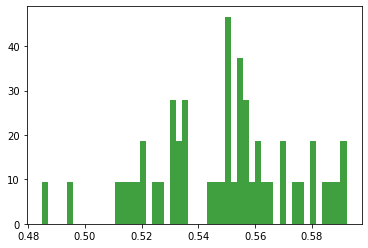

In [93]:
# the histogram of the data
n, bins, patches = plt.hist(np.array(null_hist), 20, density=True, facecolor='g', alpha=0.75)